# Práctica Minería de Datos

**Este documento contiene la parte práctica de la tarea de evaluación del módulo de Minería de Datos.** 

**La idea es que vayas avanzando en el documento y completando códigos (asegurando ejecutar para que se vean las salidas) y preguntas asociadas.**

**Una vez terminado, lo guardas con el nombre "PracticaMineria_NombreApellido.ipynb" para adjuntarlo a la entrega.** 

**A disfrutar del proceso!**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import NuestrasFunciones

import plotly.express as px
from plotly.subplots import make_subplots
#from ydata_profiling import ProfileReport
import seaborn as sns

from sklearn.metrics import r2_score
import statsmodels.api as sm

from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings('ignore')

In [3]:
plt.rcParams["figure.figsize"] = (20, 12)

## Pregunta 1

Indica en el siguiente chunk el código necesario para importar el conjunto de datos **"FEV_data.csv"** y muestra la información del archivo. 

In [4]:
# Lectura del archivo
df_fev = pd.read_csv("FEV_data.csv")
# Información
#print(df_fev.head())
#print(df_fev.describe())
#print(df_fev.dtypes)
df_fev.info

<bound method DataFrame.info of      seqnbr  subjid  age    fev  height  sex  smoke
0         1     301    9  1.708    57.0    2      2
1         2     451    8  1.724    67.5    2      2
2         3     501    7  1.720    54.5    2      2
3         4     642    9  1.558    53.0    1      2
4         5     901    9  1.895    57.0    1      2
..      ...     ...  ...    ...     ...  ...    ...
649     650   73041   16  4.270    67.0    1      1
650     651   73042   15  3.727    68.0    1      1
651     652   73751   18  2.853    60.0    2      2
652     653   75852   16  2.795    63.0    2      1
653     654   77151   15  3.211    66.5    2      2

[654 rows x 7 columns]>

**Respuesta**:
¿Cuantos registros y variables tiene el archivo? ¿Tienen las variables el tipo correcto en relación a su lógica naturaleza?

¿Cuantos registros y variables tiene el archivo?

Nuestro archivo contiene 654 registros y 7 variables.

¿Tienen las variables el tipo correcto en relación a su lógica naturaleza?

-La variable seqnbr parece ser el identificador de cada registro, empieza en uno y termina en 654. Es un int-64 y debe permanecer así.(Hipótesis confirmado con link enviado por el profe)
-La variable subjid no sé a qué hace referencia, pero tiene también 654 valores únicos de valores enteros. Debe permanecer como int64.(Link enviado por el profe indica que es otro identidicador, claro que debe permanecer como int)
-La variable age hace referencia a la edad de la persona observada en años, aparentemente sin tomar en cuenta valores intermedios.
Debe permanecer como int-64.
-La variable FEV tampoco sé a qué se refiere pero es una variable de carácter continuo. Debe permanecer como float64 (Link enviado por el profe explica qué es el FEV y confirma que tiene sentido que su medición se llev a cabo con números continuos).
- La variable height parece registrar la altura del sujeto observado aparentemente en pulgadas, toma valores enteros
y el punto medio entre dos enteros, se pudiese redondear y pasar a int64 pero se perdería información sin necesidad. La variable se debe quedar como float 64.
- Sex y Smoke son variables dicotómicas que toman valores 2 y 1 y su datatype es int64. Se deben pasar a categóricas pues sólo pueden tomar dos valores.Para cambiarlas a categórica reemplazaré los valores 1,2 por el tradicional 0,1


In [5]:
df_fev.loc[df_fev.smoke == 1, "smoke"] = 0
df_fev.loc[df_fev.smoke == 2, "smoke"] = 1

df_fev.loc[df_fev.sex == 1, "sex"] = 0
df_fev.loc[df_fev.sex == 2, "sex"] = 1

df_fev.smoke = df_fev.smoke.astype('category')
df_fev.sex = df_fev.sex.astype('category')

In [6]:
print("Bajo este nuevo formato el valor de smoke == 1 significa que el sujeto no fuma")
print("Bajo este nuevo formato el valor de gender == 1 significa que el sujeto es mujer")
df_fev.dtypes

Bajo este nuevo formato el valor de smoke == 1 significa que el sujeto no fuma
Bajo este nuevo formato el valor de gender == 1 significa que el sujeto es mujer


seqnbr       int64
subjid       int64
age          int64
fev        float64
height     float64
sex       category
smoke     category
dtype: object

## Pregunta 2

Sabiendo que la variable objetivo es *Fev*. Presenta un gráfico con las relaciones de asociación de los predictores frente a Fev. 

Creo dos columnas aleatorias. Su valor es meramente comparativo, las variables con menor asociación que ellas probablemente no sean significativas.


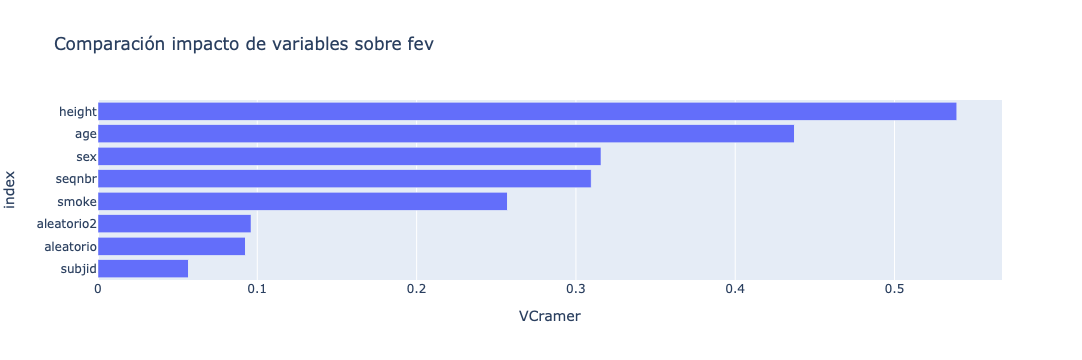

In [9]:
# Gráfico de relaciones con la objetivo
print("Creo dos columnas aleatorias. Su valor es meramente comparativo, las variables con menor asociación que ellas probablemente no sean significativas.")
df_fev['aleatorio'] = np.random.uniform(0,1,size=df_fev.shape[0])
df_fev['aleatorio2'] = np.random.uniform(0,1,size=df_fev.shape[0])
X = df_fev.drop(["fev"], axis = 1)
Y = df_fev.fev
tablaCramer = pd.DataFrame(X.apply(lambda x: NuestrasFunciones.cramers_v(x,Y)),columns=['VCramer'])
px.bar(tablaCramer,x=tablaCramer.VCramer,title='Comparación impacto de variables sobre fev').update_yaxes(categoryorder="total ascending")

¿Cuales son las 3 variables que elegirías para tu primer modelo de regresión en base a esta información?

**Respuesta**:

Sólo con la información que me provee la V de Cramer diría que las mejores 3 variables para mi regresión son height, age y sex.

Notas:
- Es extraño que smoke no muestre una fuerte interacción. Debe ser debido a su mínimo tamaño muestral positivo sólo el 11% de las observaciones muestran positivo. Se debe por supuesto a que las observaciones son niños, pero los datos parecen ir en contra del conocimiento popular que dice que fumar es malo para los pulmones. Merece la pena investigar a profundidad.
- Es extraña la fuerte asociación de seqnbr con la objetivo, curioso
- Después de transformar las variables y analizar su asociación con la objetivo, concluí que no vale la pena transformar. El único efecto que merecía la pena conservar era seqnbr^2, una variable que seguramente no entre en nuestro modelo.

                            OLS Regression Results                            
Dep. Variable:                    fev   R-squared:                       0.380
Model:                            OLS   Adj. R-squared:                  0.379
Method:                 Least Squares   F-statistic:                     399.0
Date:                Tue, 26 Dec 2023   Prob (F-statistic):           1.28e-69
Time:                        12:53:59   Log-Likelihood:                -678.07
No. Observations:                 654   AIC:                             1360.
Df Residuals:                     652   BIC:                             1369.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7107      0.054     31.970      0.0

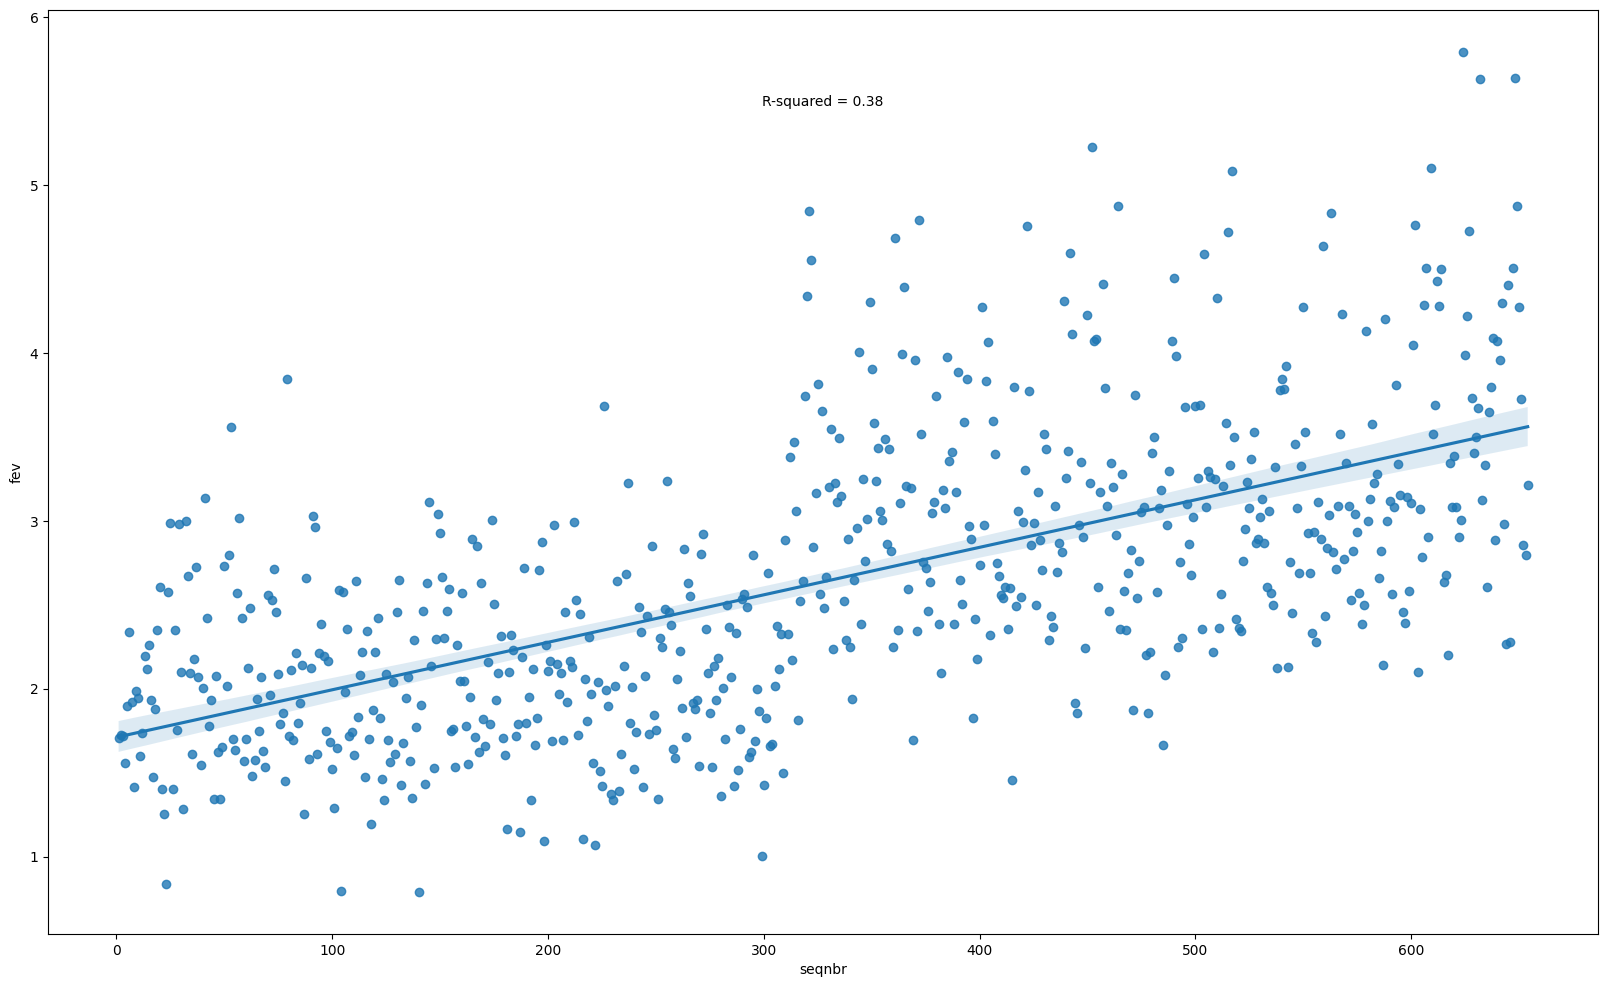

In [10]:
ax = sns.regplot(x='seqnbr', y='fev', data=df_fev)

predictor = sm.add_constant(X.seqnbr)
results = sm.OLS(Y,predictor).fit()
print(results.summary())
ax.text(0.5, 0.9, f'R-squared = {results.rsquared:.2f}', ha='center', va='center', transform=ax.transAxes)
plt.show()

In [11]:
df_prueba = X[["seqnbr","age"]]

predictor = sm.add_constant(df_prueba)
results = sm.OLS(Y,predictor).fit()
print(results.summary())
ax.text(0.5, 0.9, f'R-squared = {results.rsquared:.2f}', ha='center', va='center', transform=ax.transAxes)
plt.show()

                            OLS Regression Results                            
Dep. Variable:                    fev   R-squared:                       0.574
Model:                            OLS   Adj. R-squared:                  0.572
Method:                 Least Squares   F-statistic:                     438.0
Date:                Tue, 26 Dec 2023   Prob (F-statistic):          3.01e-121
Time:                        12:54:01   Log-Likelihood:                -555.40
No. Observations:                 654   AIC:                             1117.
Df Residuals:                     651   BIC:                             1130.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4795      0.084      5.695      0.0

Y he aquí la respuesta! Sqnbr es capaz, por sí sola, de explicar FEV, pero al incluirla en una regresión con age pierde todo su valor predictivo (p-valor = 0.137). Eso indica que posiblemente se agruparon a los niños por edades o salón de clase al llevar a cabo el experimento.

Smoke necesariamente tendrá un efecto en el FEV, revisaré si radica en interacciones
Aquí está!!! La significancia de smoke sólo se puede ver en su interacción con age


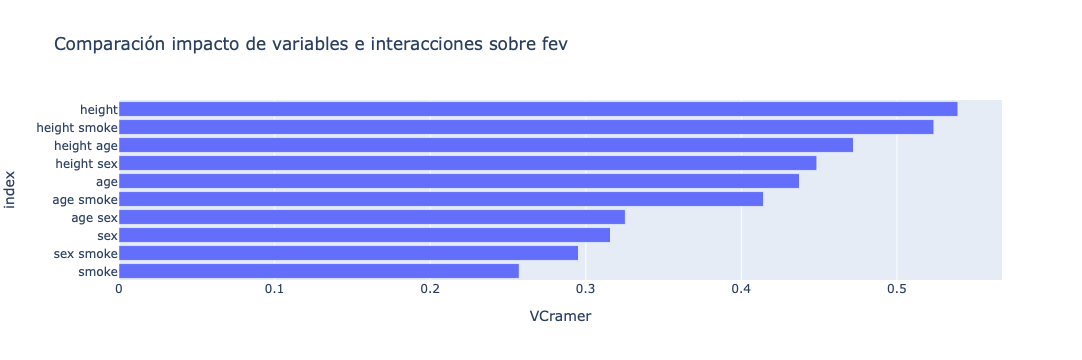

In [13]:
print("Smoke necesariamente tendrá un efecto en el FEV, revisaré si radica en interacciones")
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
clf = LinearRegression()

df_RevisarSmoke = X[["height","age","sex","smoke"]]

# Create interaction terms (interaction of each regressor pair + polynomial)
#Interaction terms need to be created in both the test and train datasets
interaction = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)

df_RevisarSmoke = pd.DataFrame(interaction.fit_transform(df_RevisarSmoke), columns=interaction.get_feature_names_out(input_features=df_RevisarSmoke.columns))
df_RevisarSmoke = df_RevisarSmoke.loc[:, df_RevisarSmoke.var() != 0.0]

print("Aquí está!!! La significancia de smoke sólo se puede ver en su interacción con age")

tablaCramer = pd.DataFrame(df_RevisarSmoke.apply(lambda x: NuestrasFunciones.cramers_v(x,Y)),columns=['VCramer'])
px.bar(tablaCramer,x=tablaCramer.VCramer,title='Comparación impacto de variables e interacciones sobre fev').update_yaxes(categoryorder="total ascending")


In [14]:
el_mejor_modelo = sfs(clf, 
          k_features=3, 
          forward=True, 
          floating=False, 
          scoring='r2',
          cv=5,n_jobs=-1)

el_mejor_modelo = el_mejor_modelo.fit(df_RevisarSmoke, Y)
print(el_mejor_modelo.k_feature_names_)
print(el_mejor_modelo.k_score_)
df_regresion_tres_variables = df_RevisarSmoke[list(el_mejor_modelo.k_feature_names_)]

('height', 'age', 'height age')
0.6604288362419497


In [15]:
ModeloInterMaquina = df_RevisarSmoke[list(el_mejor_modelo.k_feature_names_)]
ModeloInterMio = df_RevisarSmoke[["height","height smoke", "height age"]]

predictor = sm.add_constant(ModeloInterMio)
model = sm.OLS(Y,predictor).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    fev   R-squared:                       0.774
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     740.4
Date:                Tue, 26 Dec 2023   Prob (F-statistic):          3.75e-209
Time:                        12:54:55   Log-Likelihood:                -348.42
No. Observations:                 654   AIC:                             704.8
Df Residuals:                     650   BIC:                             722.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -3.8785      0.272    -14.241      0.000      -4.413      -3.344
height           0.0934      0.006     16.003      0.000       0.082       0.105
height smoke     0.0020      0.001      2.208      0.028       0.000       0.004
height age       0.0011      0.000      7.568      0.000       0.001       0.001
==============================================================================
Omnibus:                       28.338   Durbin-Watson:                   1.662
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               58.045
Skew:                           0.249   Prob(JB):                     2.49e-13
Kurtosis:                       4.372   Cond. No.                     1.12e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.12e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [16]:
predictor = sm.add_constant(ModeloInterMaquina)
model = sm.OLS(Y,predictor).fit()
print("Es una lástima pero al final smoke no entra en los predictores y el mejor modelo parece ser el de la máquina.")
print("Probablemente smoke no tiene tanto poder predictivo porque estudiamos niños quienes tienen poco tiempo fumando.")
model.summary()

Es una lástima pero al final smoke no entra en los predictores y el mejor modelo parece ser el de la máquina.
Probablemente smoke no tiene tanto poder predictivo porque estudiamos niños quienes tienen poco tiempo fumando.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    fev   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.789
Method:                 Least Squares   F-statistic:                     814.4
Date:                Tue, 26 Dec 2023   Prob (F-statistic):          1.17e-219
Time:                        12:54:56   Log-Likelihood:                -324.07
No. Observations:                 654   AIC:                             656.1
Df Residuals:                     650   BIC:                             674.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6636      0.510     -1.301      0.194      -1.665       0.338
height         0.0458      0.009      5.244      0.000       0.029       0.063
age           -0.4182      0.056     -7.450      0.000      -0.528      -0.308
height age     0.0075      0.001      8.518      0.000       0.006       0.009
==============================================================================
Omnibus:                       25.962   Durbin-Watson:                   1.644
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               69.070
Skew:                           0.010   Prob(JB):                     1.00e-15
Kurtosis:                       4.592   Cond. No.                     2.18e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.18e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Pregunta 3

Ajusta el modelo de regresión que contiene los 3 predictores que has decidido en el apartado anterior en el propio conjunto de entrenamiento (no hace falta hacer partición) y muestra el summary de dicho modelo. 

In [17]:
# Ajuste de modelo 
predictor = sm.add_constant(ModeloInterMaquina)
model = sm.OLS(Y,predictor).fit()
# Summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    fev   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.789
Method:                 Least Squares   F-statistic:                     814.4
Date:                Tue, 26 Dec 2023   Prob (F-statistic):          1.17e-219
Time:                        12:54:58   Log-Likelihood:                -324.07
No. Observations:                 654   AIC:                             656.1
Df Residuals:                     650   BIC:                             674.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6636      0.510     -1.301      0.194      -1.665       0.338
height         0.0458      0.009      5.244      0.000       0.029       0.063
age           -0.4182      0.056     -7.450      0.000      -0.528      -0.308
height age     0.0075      0.001      8.518      0.000       0.006       0.009
==============================================================================
Omnibus:                       25.962   Durbin-Watson:                   1.644
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               69.070
Skew:                           0.010   Prob(JB):                     1.00e-15
Kurtosis:                       4.592   Cond. No.                     2.18e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.18e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

 A la vista de los valores de ajuste, ¿qué porcentaje de variabilidad explicada tiene el modelo? Interpreta el parámetro estimado de la *altura*.

**Respuesta**:

El porcentaje de variablididad explicada por el modelo es de 79%.

El parametro altura significa que por cada aumento unitario de altura (supongo que en pulgadas), el fev subirá en 0.0458 unidades.

Pero al tener un efecto interacción positivo con age, podemos ver que el efecto que tiene la altura en el fev se ve positivamente afectado por la edad del sujeto.

Por cada aumento unitario de Altura, manteniendo la edad constante, el efecto total será de 0.0458 + edad*0.0075

## Pregunta 4

Aplica validación cruzada repetida para tu modelo con nuestra querida función *cross_val_lin* y una semilla conformada por los 4 últimos dígitos de tu documento de identidad. Muestra el boxplot de sesgo-varianza de las estimaciones. 

Modelo: fev ~ height + age + height_age
Coeficiente de determinación R2: 0.783 (0.037)


<Axes: >

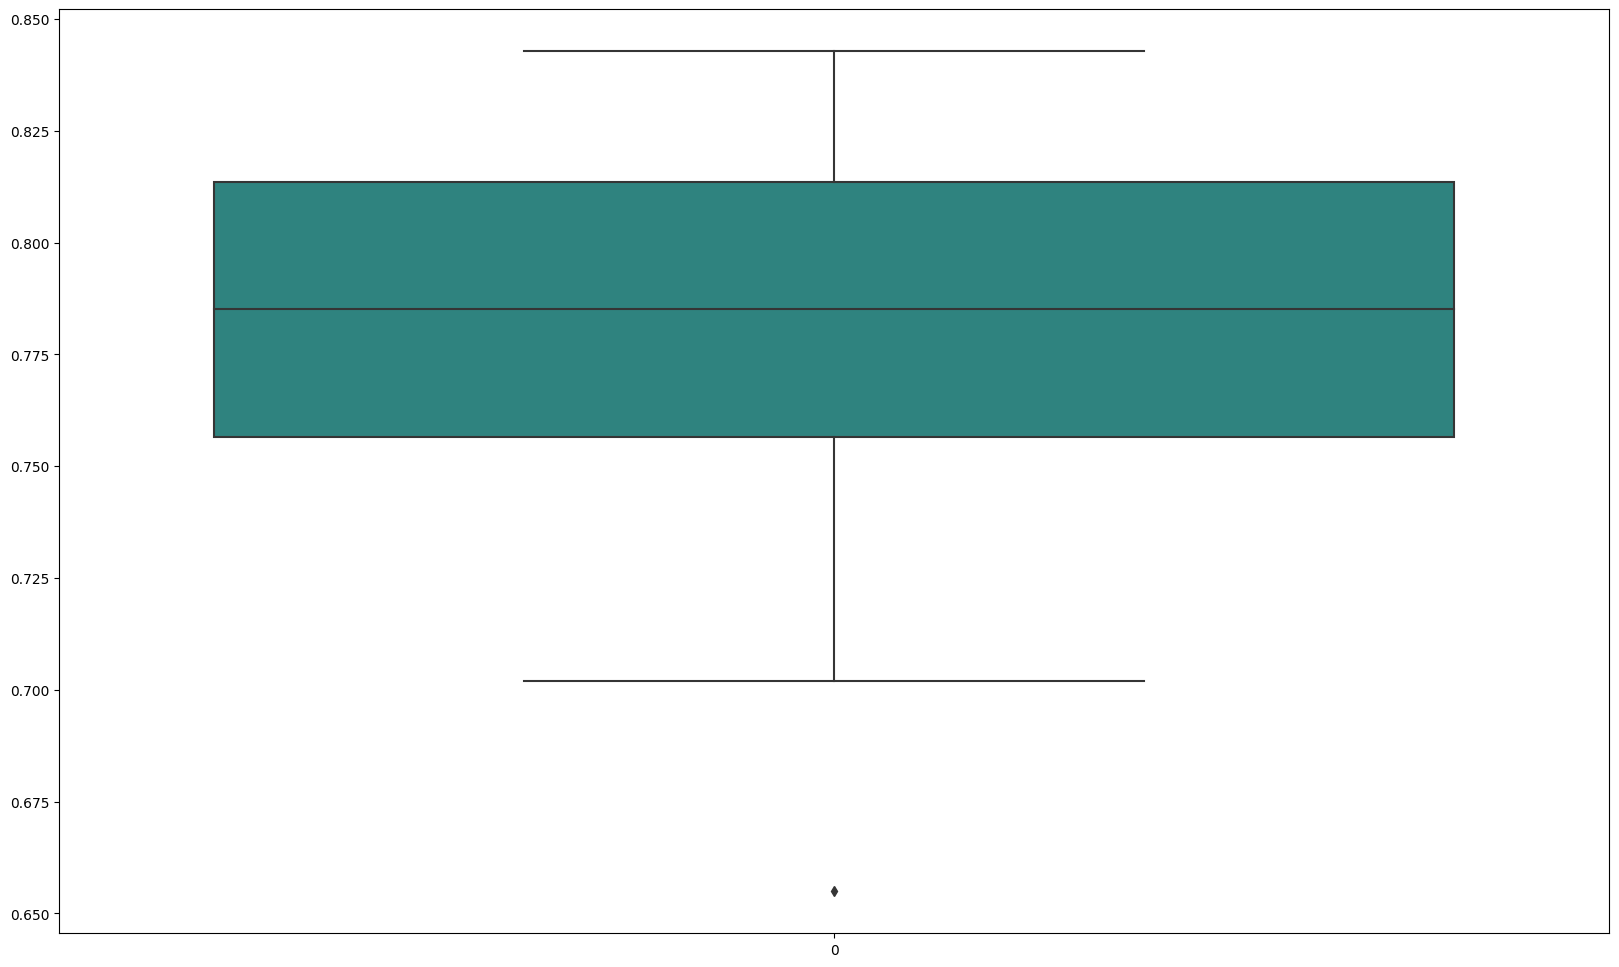

In [18]:
# Validación cruzada
ModeloInterMaquina.rename(columns={"height age":"height_age"}, inplace = True)
df_regresion_cross_val = ModeloInterMaquina.join(Y)
formula = "fev ~ height + age + height_age"

para_box = NuestrasFunciones.cross_val_lin(formula = formula, data = df_regresion_cross_val ,seed = 7211)

sns.boxplot(data=para_box,palette='viridis')
# Boxplot sesgo-varianza


A la vista de los resultados. ¿Está sobreajustando tu modelo al conjunto de entrenamiento?

**Respuesta**:

Mi modelo no parece estar sobreajustando. Tiene un R^2 medio de 0.783, con una desviación estándar de 0.037.
Los resultados no son mucho peores que el modelo original sin validación cruzada cuyo R^2 era de 0.79.

Sin embargo sí podemos ver un R^2 en 0.650. Un test que salió muy mal, pero como el agregado de desviación típíca es bajo no nos debe causar mucha preocupación. Se debe probablemente a una partición atípica de los datos en ese conjunto específico.

## Pregunta 5

Indica el código necesario para leer el conjunto de datos **"IPI_Esp.xlsx"** y muestra su cabeza.

In [19]:
# Lectura de datos IPI
df_IPI = pd.read_excel("IPI_Esp.xlsx")
# Primeras filas
df_IPI

,Date,IPI Nacional
0,1975M01,70.658
1,1975M02,72.180
2,1975M03,75.732
3,1975M04,74.844
4,1975M05,74.210
...,...,...
534,2019M07,114.698
535,2019M08,85.929
536,2019M09,106.408
537,2019M10,114.592


## Pregunta 6

Convierte el conjunto en una serie temporal legible para Python y representa gráficamente la evolución. 

In [20]:
# Conversión a serie temporal legible
fechas = pd.date_range(start='1/1/1975',end = "12/2019", freq = "M")
df_IPI["Date"] = fechas

In [21]:
# Convertir en date-time
df_IPI.set_index("Date",inplace=True)
df_IPI.rename(columns = {"IPI Nacional": "IPI_Nacional"}, inplace = True)

In [22]:
# Mostrar valores de serie
df_IPI

,IPI_Nacional
Date,
1975-01-31,70.658
1975-02-28,72.180
1975-03-31,75.732
1975-04-30,74.844
1975-05-31,74.210
...,...
2019-07-31,114.698
2019-08-31,85.929
2019-09-30,106.408


<Axes: xlabel='Date'>

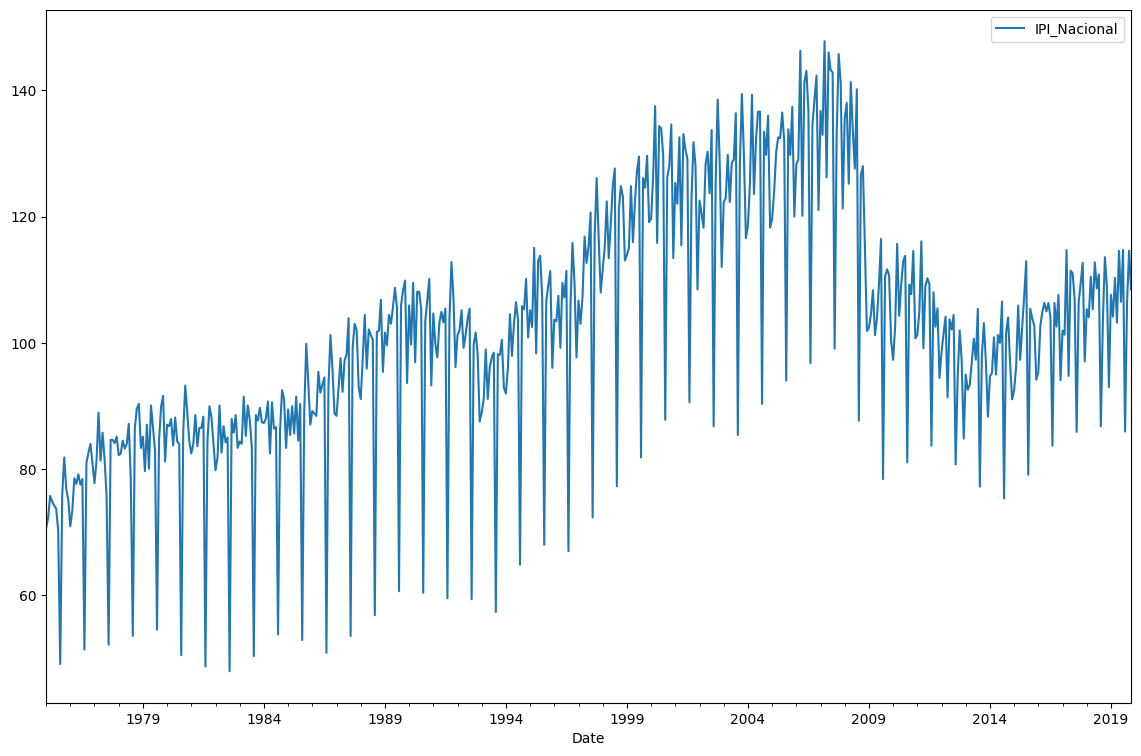

In [23]:
# Gráfico de evolución del IPI
df_IPI.plot(figsize=(14, 9))

¿Qué componentes de la serie se pueden intuir en el gráfico?

**Respuesta**:

-Se puede ver una muy fuerte estacionalidad. La fuerza de la estacionalidad parece disminuir luego de la crisis del 2008.
-Se puede observar una tendencia positiva hasta la crisis del 2008. Después de esto no hay tendencia.
-Si no fuese por los datos posteriores a 2008 estaríamos frente a una serie relativamente homoesquedástica, pero la varianza de los datos posteriores a 2008 es mucho menor que aquella anterior a la crisis.

Tendría sentido hacer un análisis multivariante con alguna variable que ayude a explicar la caida por la crisis del 2008

## Pregunta 7

Toma una partición con ventana de entrenamiento (todo el histórico hasta diciembre de 2017) y prueba (2018 y 2019). Ajusta el modelo de suavizado que consideres más adecuado a la luz de las características de la serie. Evalua el modelo en términos de error y adecuación de los residuos. ¿El modelo satisface las condiciones residuales en cuanto a  autocorrelaciones?

In [24]:
# Partición de datos
import statsmodels.tsa.holtwinters as ets
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

df_IPI_tr = df_IPI[:'2017-12-31']
df_IPI_tst = df_IPI['2018-01-31':]
# Ajuste de modelo de suavizado




<Figure size 2000x1200 with 0 Axes>

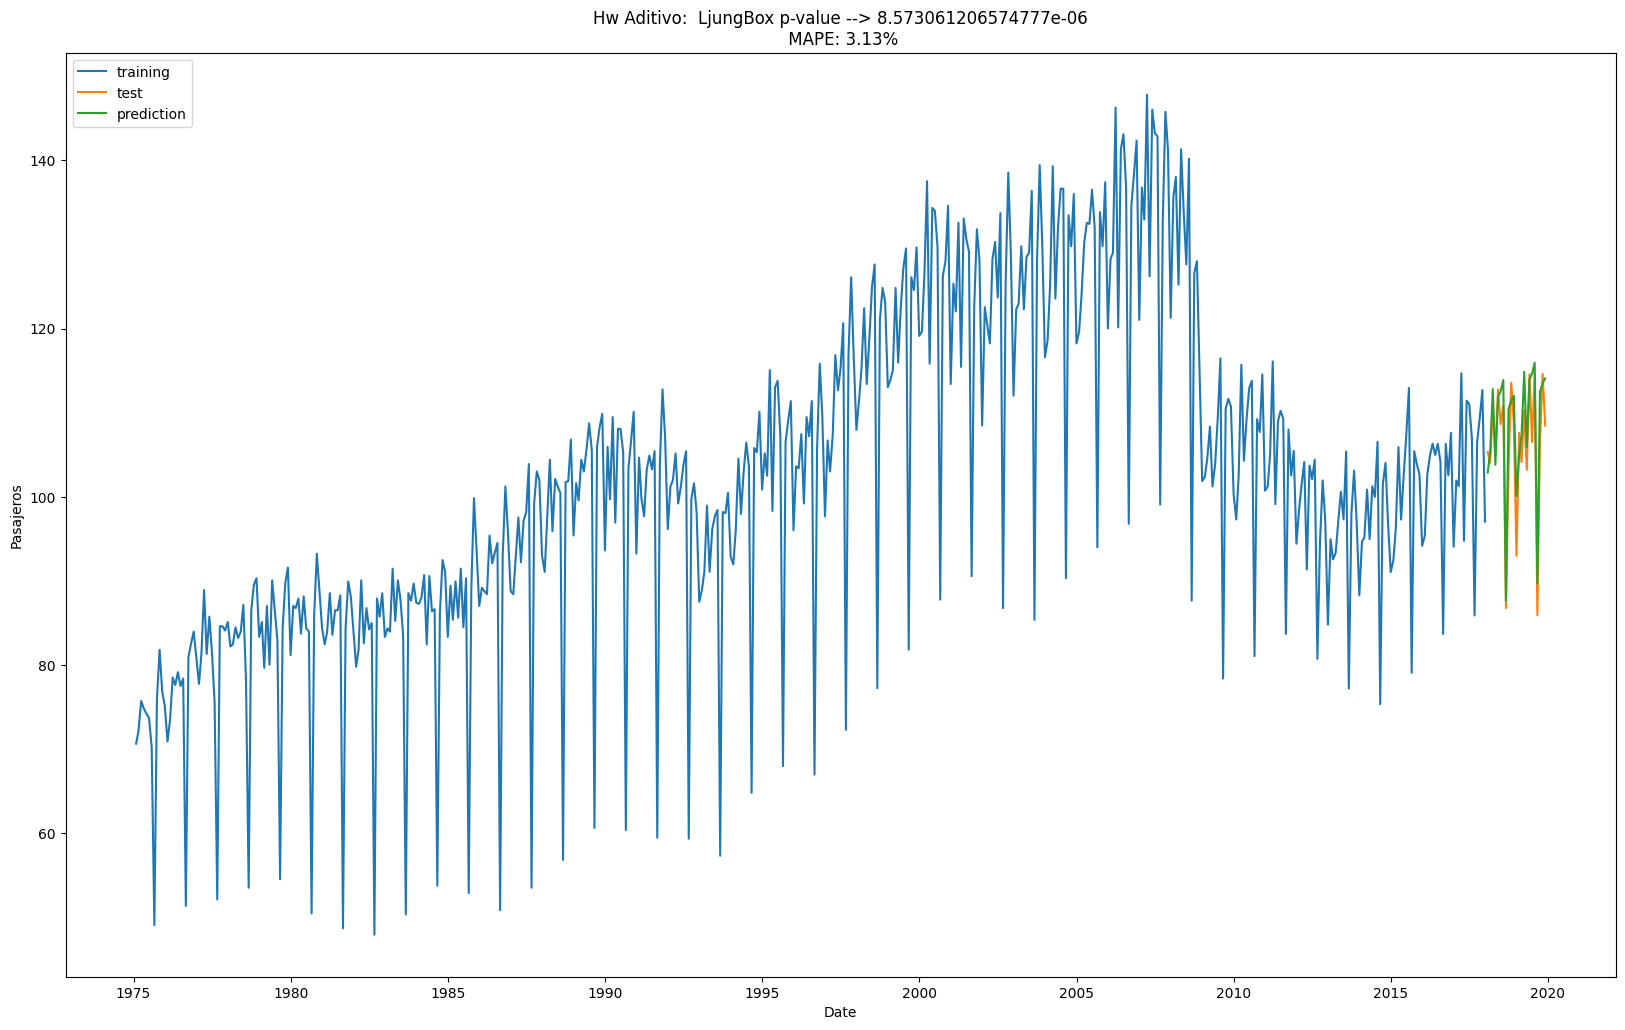

8.573061206574777e-06


In [25]:
#plt.figure(figsize=(20, 6))
holtwinters_add = ets.ExponentialSmoothing(df_IPI_tr,trend='add', damped_trend=False, seasonal='add',use_boxcox = True).fit()
NuestrasFunciones.eval_model(holtwinters_add,df_IPI_tr,df_IPI_tst,'Hw Aditivo')

**Respuesta**:

El modelo de suavizado exponencial aditivo (el multi es algo peor) logra captar la serie temporal y produce un MAPE bajo, pero falla el test de ljungBox, teniendo un p-valor menor a 0.05. Que exista autocorrelación de los residuos nos lleva a la conclusión de que hay algo que nuestro modelo no está captando, puede ser mejorado.


## Pregunta 8

Presenta los correlogramas simple y parcial de la serie diferenciada en lo regular y estacional para el conjunto de entrenamiento. 

serie diferenciada en lo regular:
Results of Dickey-Fuller Test:
Test Statistic                  -4.263661
p-value                          0.000513
#Lags Used                      19.000000
Number of Observations Used    495.000000
Critical Value (1%)             -3.443630
Critical Value (5%)             -2.867397
Critical Value (10%)            -2.569889
dtype: float64


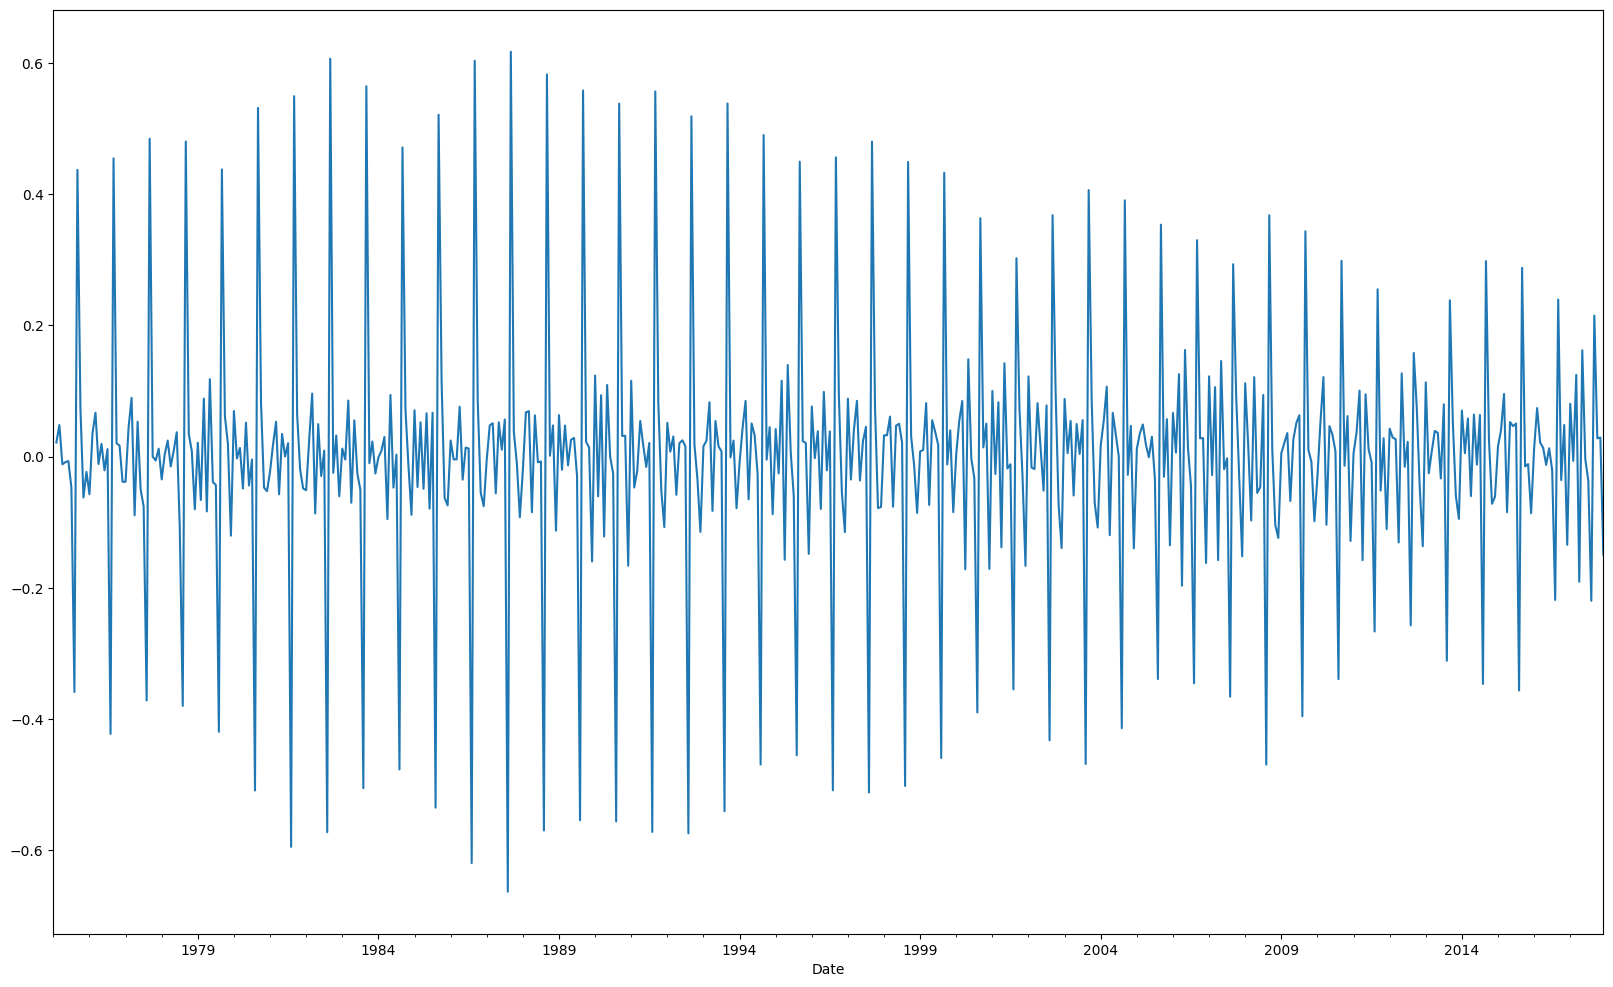

serie diferenciada en lo regular y estacional:
Results of Dickey-Fuller Test:
Test Statistic                -8.420615e+00
p-value                        1.988238e-13
#Lags Used                     1.600000e+01
Number of Observations Used    4.860000e+02
Critical Value (1%)           -3.443877e+00
Critical Value (5%)           -2.867505e+00
Critical Value (10%)          -2.569947e+00
dtype: float64


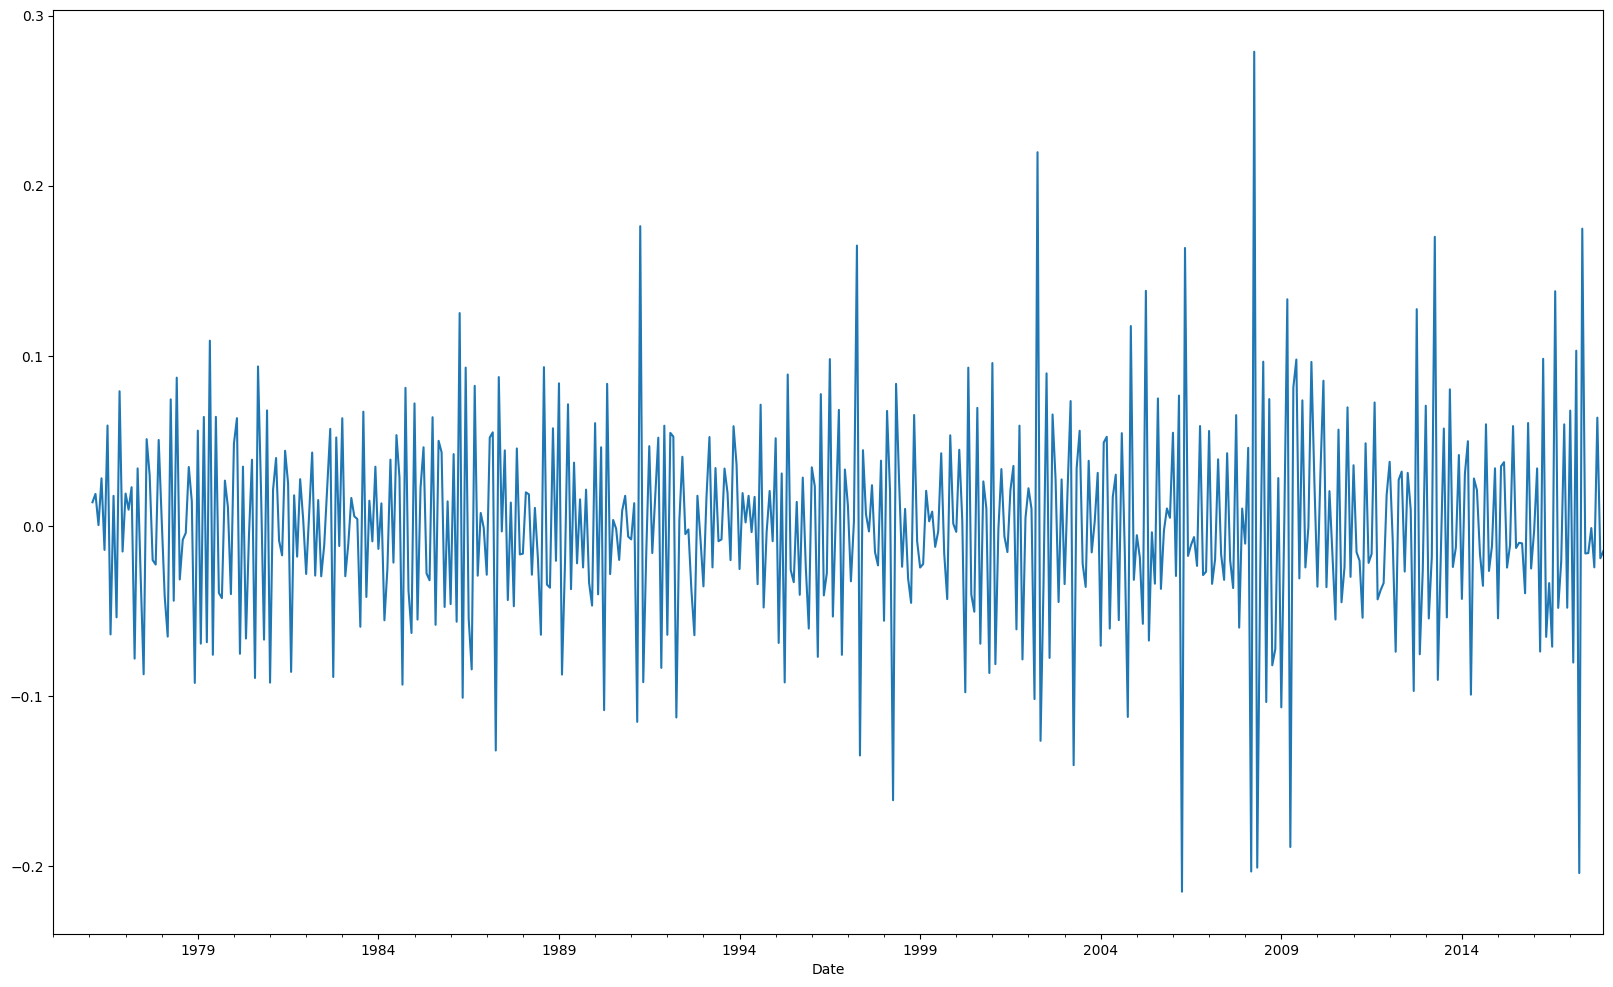


ACF de la serie diferenciada en lo con su lag y en lo estacional:


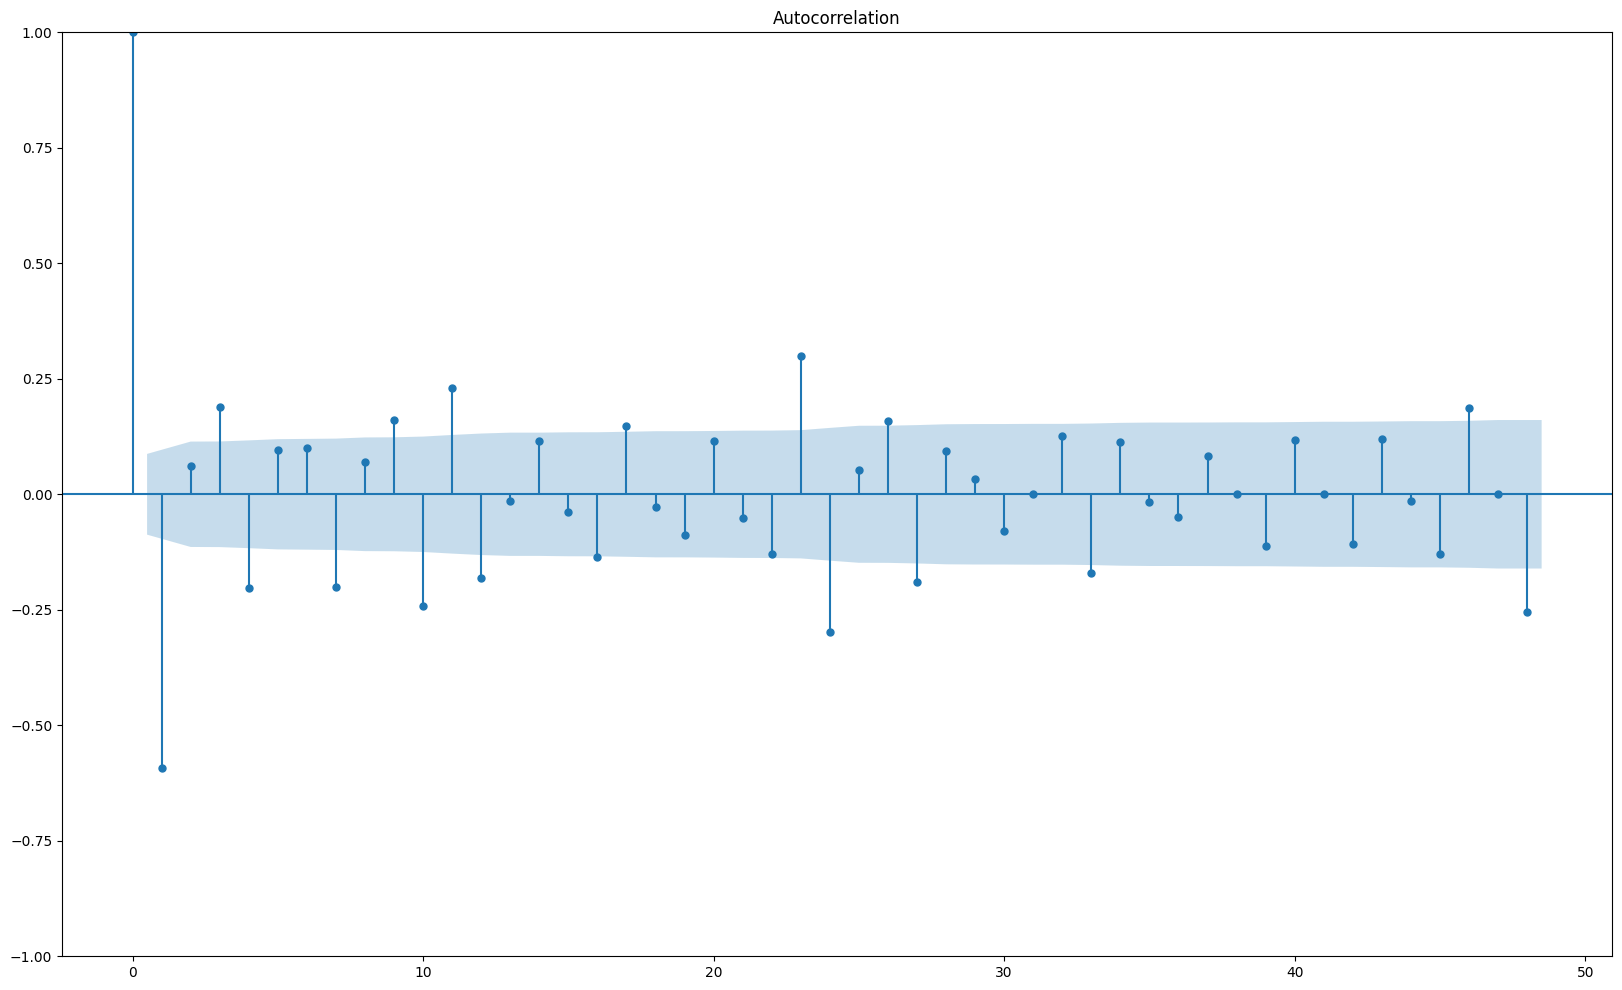

PACF de la serie diferenciada en lo con su lag y en lo estacional:


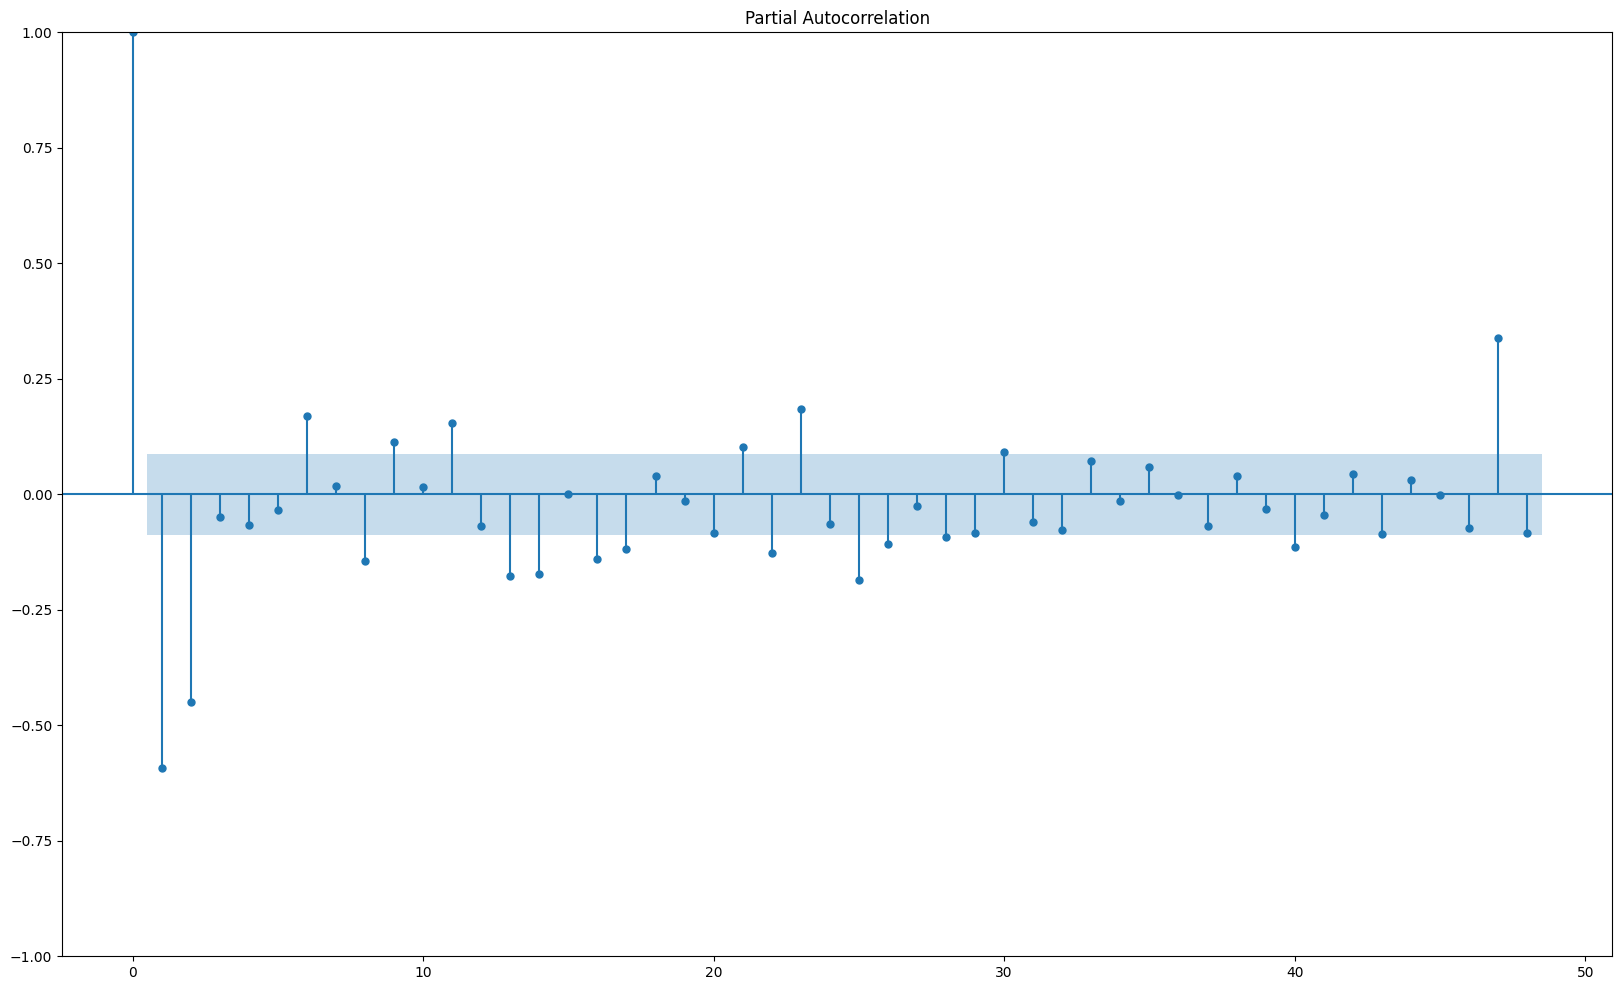

In [26]:
# Diferenciar serie
#Le aplicaré la transformación BOX-COX para reducir la varianza y conseguir mejores resultados
#plt.figure(figsize=(16, 8))
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

IPI_log_tr = np.log(df_IPI_tr['IPI_Nacional'])
IPI_log_tst = np.log(df_IPI_tst['IPI_Nacional'])

Ipi_log_diff_1_tr = IPI_log_tr.diff(periods=1)
Ipi_log_diff_1_12_tr = Ipi_log_diff_1_tr.diff(periods=12)
print("serie diferenciada en lo regular:")
Ipi_log_diff_1_tr.plot()
NuestrasFunciones.test_stationarity(Ipi_log_diff_1_tr.dropna(inplace = False))
plt.show()
print("serie diferenciada en lo regular y estacional:")
NuestrasFunciones.test_stationarity(Ipi_log_diff_1_12_tr.dropna(inplace=False))
Ipi_log_diff_1_12_tr.plot()
plt.show()
# Correlograma simple ACF
print()
plot_acf(Ipi_log_diff_1_12_tr.dropna(inplace=False), lags = 48)
print("ACF de la serie diferenciada en lo con su lag y en lo estacional:")
plt.show()
# Correlograma simple ACF
print("PACF de la serie diferenciada en lo con su lag y en lo estacional:")
plot_pacf(Ipi_log_diff_1_12_tr.dropna(inplace=False), lags = 48)
plt.show()
# Correlograma parcial PACF


A pesar de la dificultad, intentemos proponer algunos órdenes en lo regular y estcional para un tentativo modelo arima. 

¿Cual sería tu primer modelo a probar según lo que observas en la desaparición de las correlaciones con los retardos?

**Respuesta**: Mi modelo sería ARIMA(p,d,q)(P,D,Q)

**PACF:** En lo regular hay un claro corte después del segundo lag, indica un claro AR(2). En lo estacional puede que haya un decrecimiento leve, lo que indicaría un MA estacional.

**ACF:** En lo regular parece haber un conjunto de corte después del primer lag y un decrecimiento algo leve, esto indica un MA(1). En lo estacional está un tanto más difícil de ver, pero yo diría que hay un corte después del segundo lag estacional MA(2).

**Integrado:** la serie es estacionaria al hacer la primera diferencia, el p-valor baja al llevar a cabo diferencias en lo estacional pero no parece ser necesario


el proceso debe de ser ARIMA(2,1,1)(0,(1/0),2) pero lo mejor sería probar diferentes posibildades antes de presentar cualquier determinado modelo

## Pregunta 9

Ajusta ese modelo que propones y evalúa su capacidad de ajuste en test y la adecuación de residuos. 

In [27]:
# Ajuste de modelo ARIMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

modelo_IPI_1 = SARIMAX(IPI_log_tr, 
                order = (2, 1, 1), 
                seasonal_order =(0, 0, 2, 12)).fit(disp=False)

In [28]:
# Summary del modelo 
modelo_IPI_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                            IPI_Nacional   No. Observations:                  516
Model:             SARIMAX(2, 1, 1)x(0, 0, [1, 2], 12)   Log Likelihood                 618.839
Date:                                 Tue, 26 Dec 2023   AIC                          -1225.678
Time:                                         12:55:07   BIC                          -1200.213
Sample:                                     01-31-1975   HQIC                         -1215.698
                                          - 12-31-2017                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1042      0.050      2.064      0.039       0.005       0.203
ar.L2          0.1389      0.050      2.762      0.006       0.040       0.237
ma.L1         -0.9285      0.021    -45.136      0.000      -0.969      -0.888
ma.S.L12       1.2259      0.033     37.513      0.000       1.162       1.290
ma.S.L24       0.5065      0.032     15.595      0.000       0.443       0.570
sigma2         0.0051      0.000     18.309      0.000       0.005       0.006
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):               112.76
Prob(Q):                              0.73   Prob(JB):                         0.00
Heteroskedasticity (H):               0.93   Skew:                            -0.96
Prob(H) (two-sided):                  0.63   Kurtosis:                         4.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

¿Son todos los efectos significativos en el modelo?

**Respuesta**: Sí lo son! Todos los coeficientes tienen un p-valor < 0.05

<Figure size 2000x1200 with 0 Axes>

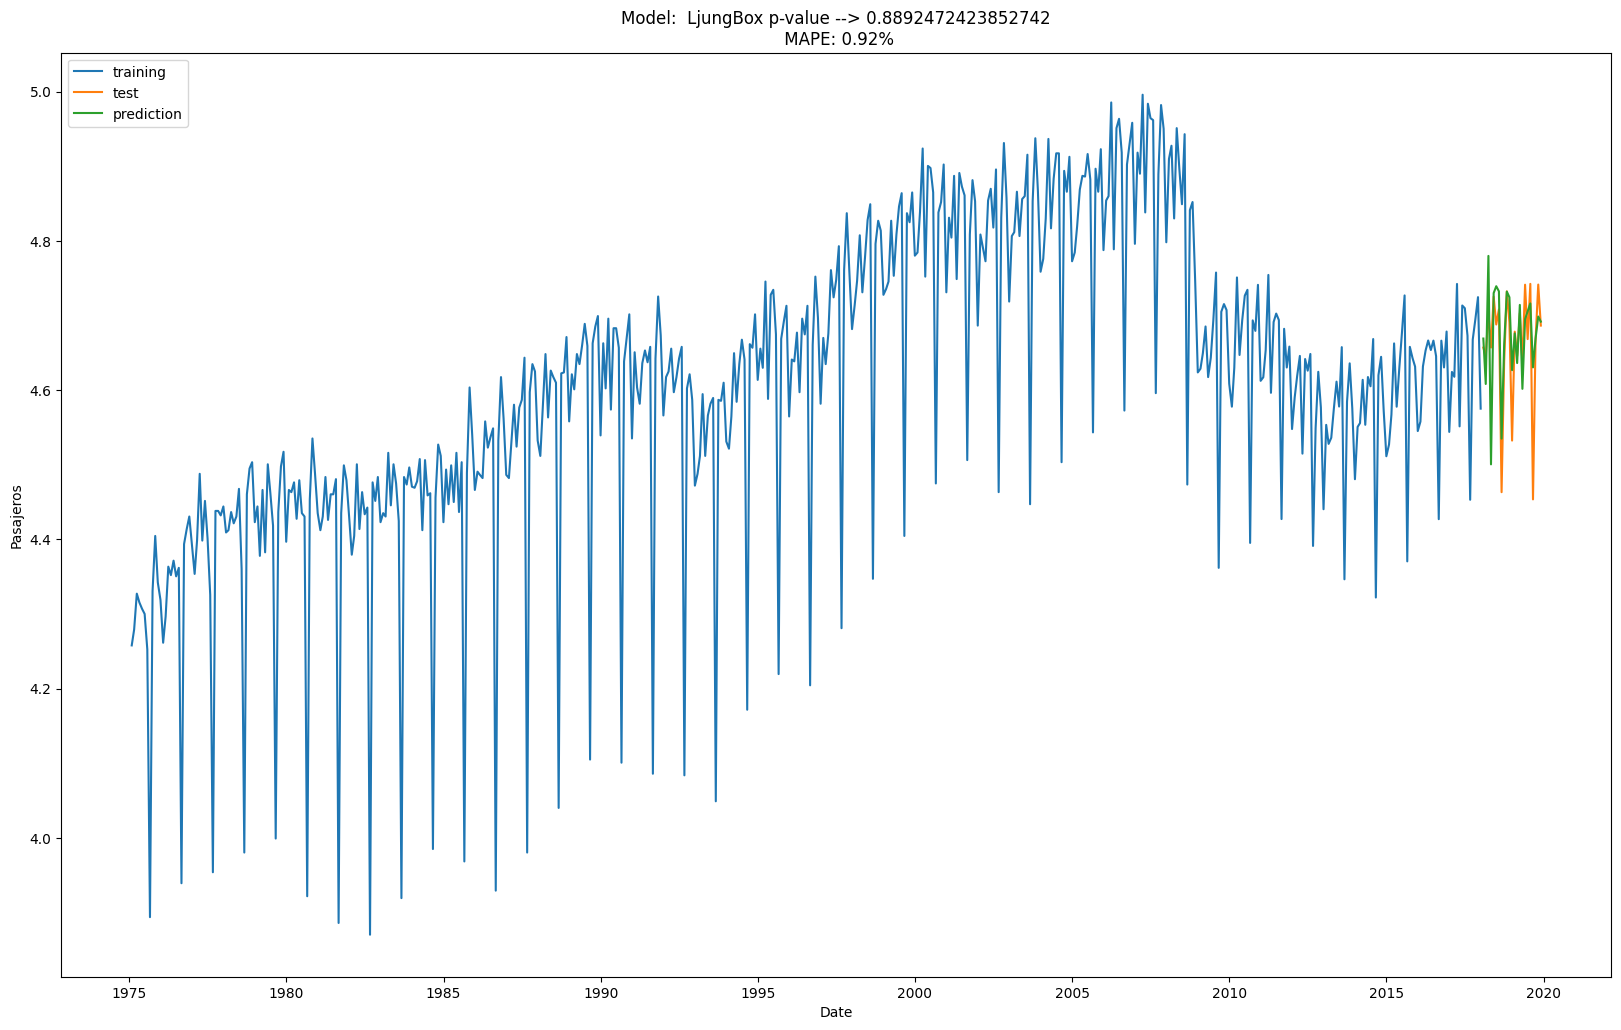

0.8892472423852742


In [29]:
# Evaluación del modelo (eval_model)
NuestrasFunciones.eval_model(modelo_IPI_1,IPI_log_tr,IPI_log_tst)

¿Es tu modelo válido para la predicción en términos de adecuación residual? En caso contrario, juega con los órdenes para obtener un modelo que satisfaga el test de residuos. ¿Es este modelo aceptable mejor que el suavizado en términos de capacidad de predicción en el conjunto de test? 

**Respuesta**: 

- El modelo tiene un valor de p-avalor del test de Ljung-Box de 0.889 con este valor podemos concluir que los residuos no están autocorrelacionados y que el modelo es válido para la predicción en términos de adecuación residual.
- En cuanro a capacidad de predicción en el conjunto de test, este modelo es mucho mejor que el suavizado exponencial llevado antes a cabo, tiene un MAPE mucho menor.
- El mejor modelo que logré encontrar lo hizo autoarima. Siendo este un ARIMA(2,1,3)(1,0,1)(12) con un MAPE de 0.57% y Ljung-Box de 0.893.
- El peor modelo lo hizo Prophet de META con un MAPE de 16% puede que esté mal calibrado para datos no diarioss, puede que yo no lo sepa usar.

## Pregunta 10

Indica el código necesario para leer el archivo **"clientes_cluster.csv"** y mostrar sus primeros registros. 

In [30]:
# Lectura clientes_cluster
df_clientes = pd.read_csv("clientes_cluster.csv")
df_clientes.rename(columns = {"Spending Score (1-100)":"Spending_score"},inplace = True)
df_clientes

,CustomerID,Gender,Age,Annual Income (k$),Spending_score
0,1,Male,19.0,15.0,39.0
1,2,Male,21.0,15.0,NaN
2,3,Female,20.0,16.0,6.0
3,4,Female,23.0,16.0,NaN
4,5,Female,31.0,NaN,40.0
...,...,...,...,...,...
195,196,Female,35.0,120.0,79.0
196,197,Female,45.0,126.0,28.0
197,198,Male,32.0,126.0,74.0
198,199,Male,32.0,137.0,18.0


## Pregunta 11

Evalúa la incidencia de valores perdidos por variable e imputa el archivo mediante el método multivariante basado en el algoritmo KNN, generando un nuevo archivo completo **"clientes_imputed"** del que se mostrará la información para comprobar que efectivamente todos los registros contienen valores válidos.

In [31]:
#Incidencia de missings por variable
print(df_clientes.apply(lambda x: x.isna().sum()))

CustomerID             0
Gender                15
Age                   13
Annual Income (k$)     9
Spending_score        18
dtype: int64


In [32]:
df_clientes.loc[df_clientes["Gender"] == "Male", "Gender"] = 1
df_clientes.loc[df_clientes["Gender"] == "Female","Gender"] = 0
df_clientes.dtypes

CustomerID              int64
Gender                 object
Age                   float64
Annual Income (k$)    float64
Spending_score        float64
dtype: object

**Comentario**: 
Los missings de la variable Gender no se podían imputar sin antes ser pasada la variable a dicotómica. El problema que descubrí es que luego la imputación por knn pasará la variable a float y le otorgará valores intermedios. Para remediarlo rendondearé ese output.

In [33]:
# Imputación por KNN
import sklearn.impute as skl_imp
imputer_knn = skl_imp.KNNImputer(n_neighbors=3)
clientes_imputed = pd.DataFrame(imputer_knn.fit_transform(df_clientes),columns=df_clientes.columns)
# Info del archivo imputado
type(clientes_imputed)
print(clientes_imputed.apply(lambda x: x.isna().sum()))

CustomerID            0
Gender                0
Age                   0
Annual Income (k$)    0
Spending_score        0
dtype: int64


Recodifica *Gender* como una variable dummy (cualquier opción de código es bienvenida) en formato numérico y elimina el ID de cliente de cara al análisis.

In [34]:
# Recodificación de Gender como dummy Ya se hizo, aquí se pasará otra vez a categorical.
clientes_imputed["Gender"] = round(clientes_imputed.Gender)
clientes_imputed.Gender = clientes_imputed.Gender.astype('category')

In [35]:
clientes_imputed.drop(["CustomerID"],axis = 1, inplace = True)

In [36]:
print(clientes_imputed.apply(lambda x: x.isna().sum()))

Gender                0
Age                   0
Annual Income (k$)    0
Spending_score        0
dtype: int64


## Pregunta 12

Explora los métodos de clustering jerárquico para formar grupos de clientes similares en cuanto a su comportamiento en estas 4 variables disponibles y presenta sus dendogramas. Si lo consideras necesario, escala los datos previamente.

In [37]:
# Clustering jerárquico bucle de dendogramas
from sklearn.preprocessing import scale
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

clientes_imputed_scale = scale(clientes_imputed)
clientes_imputed.dtypes

Gender                category
Age                    float64
Annual Income (k$)     float64
Spending_score         float64
dtype: object

ward


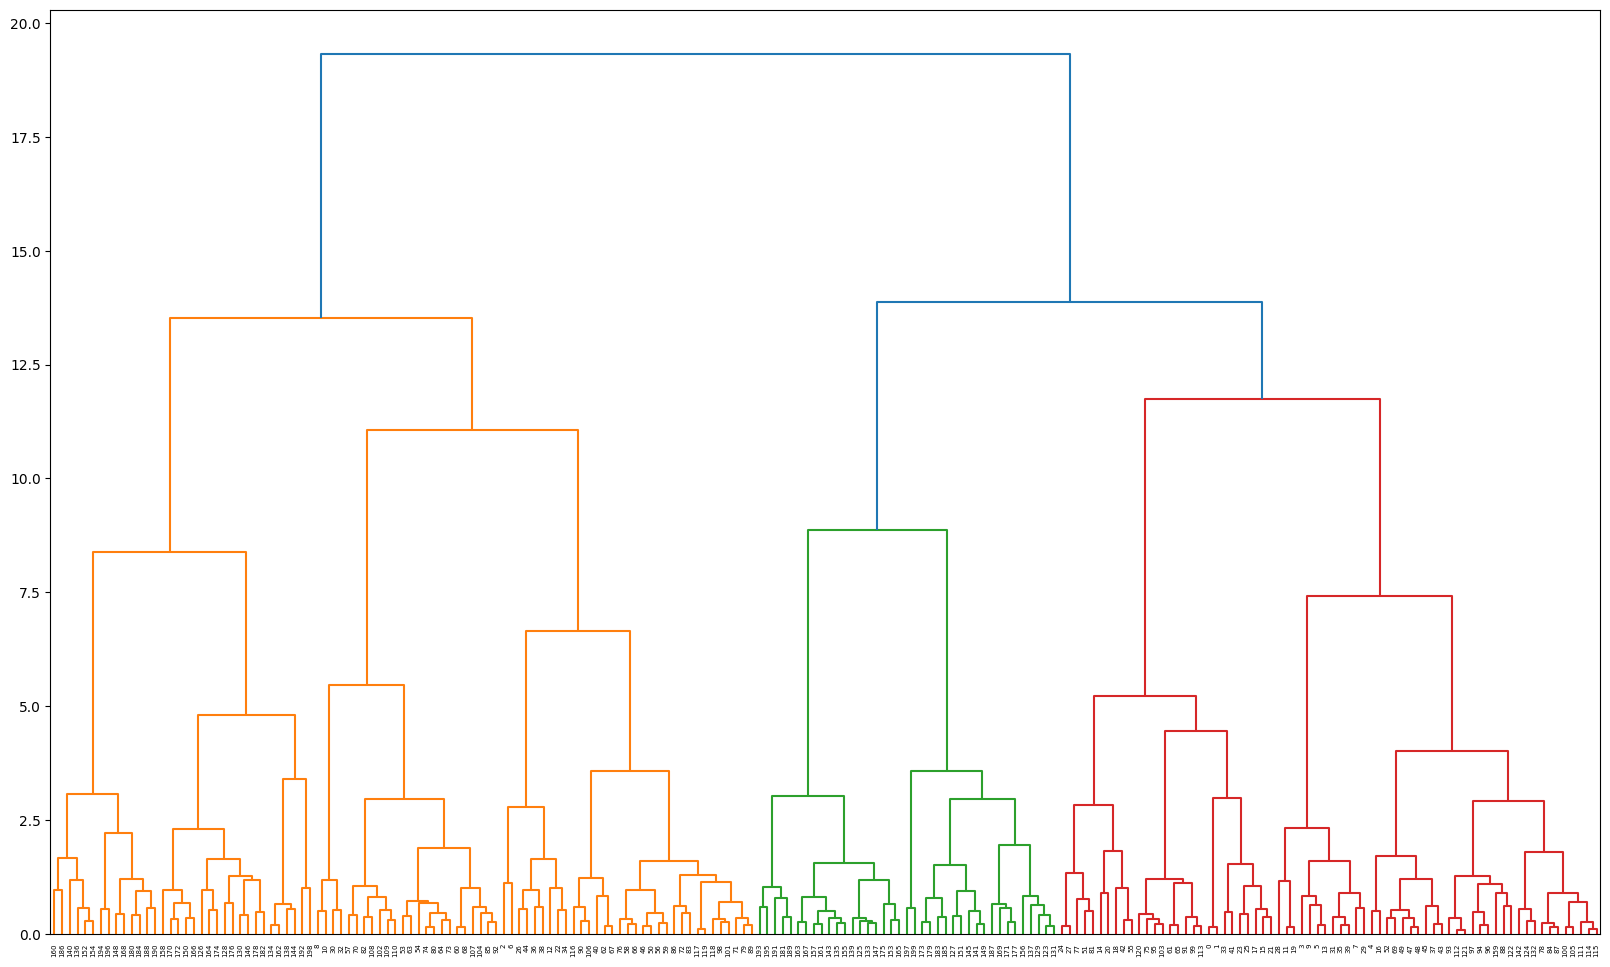

average


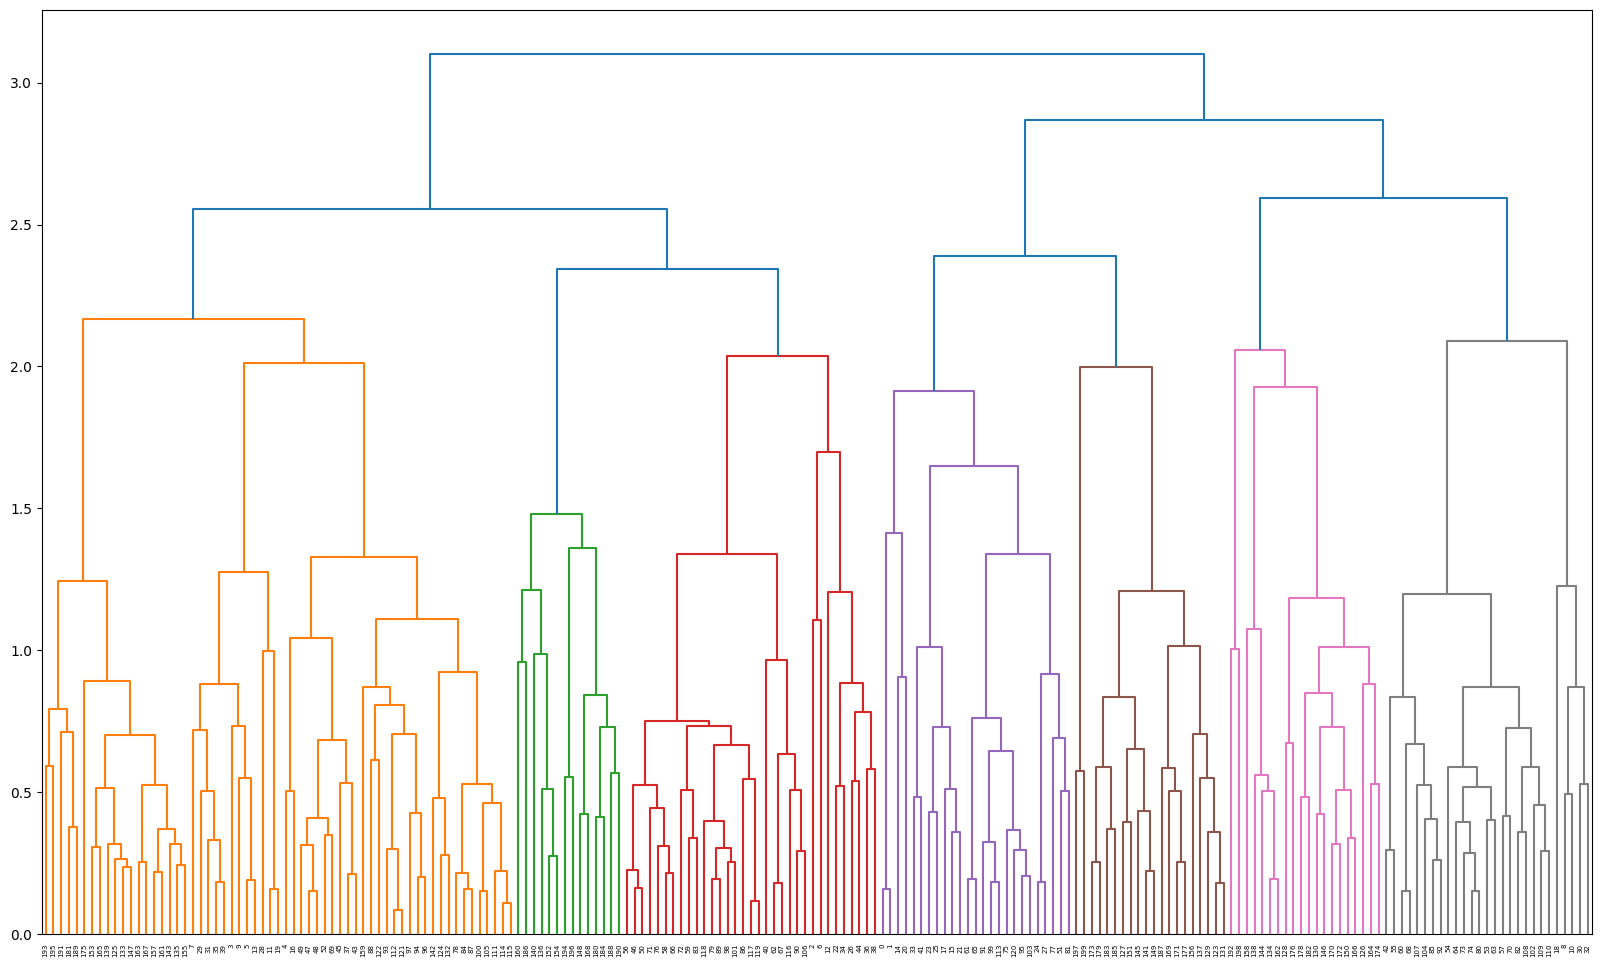

complete


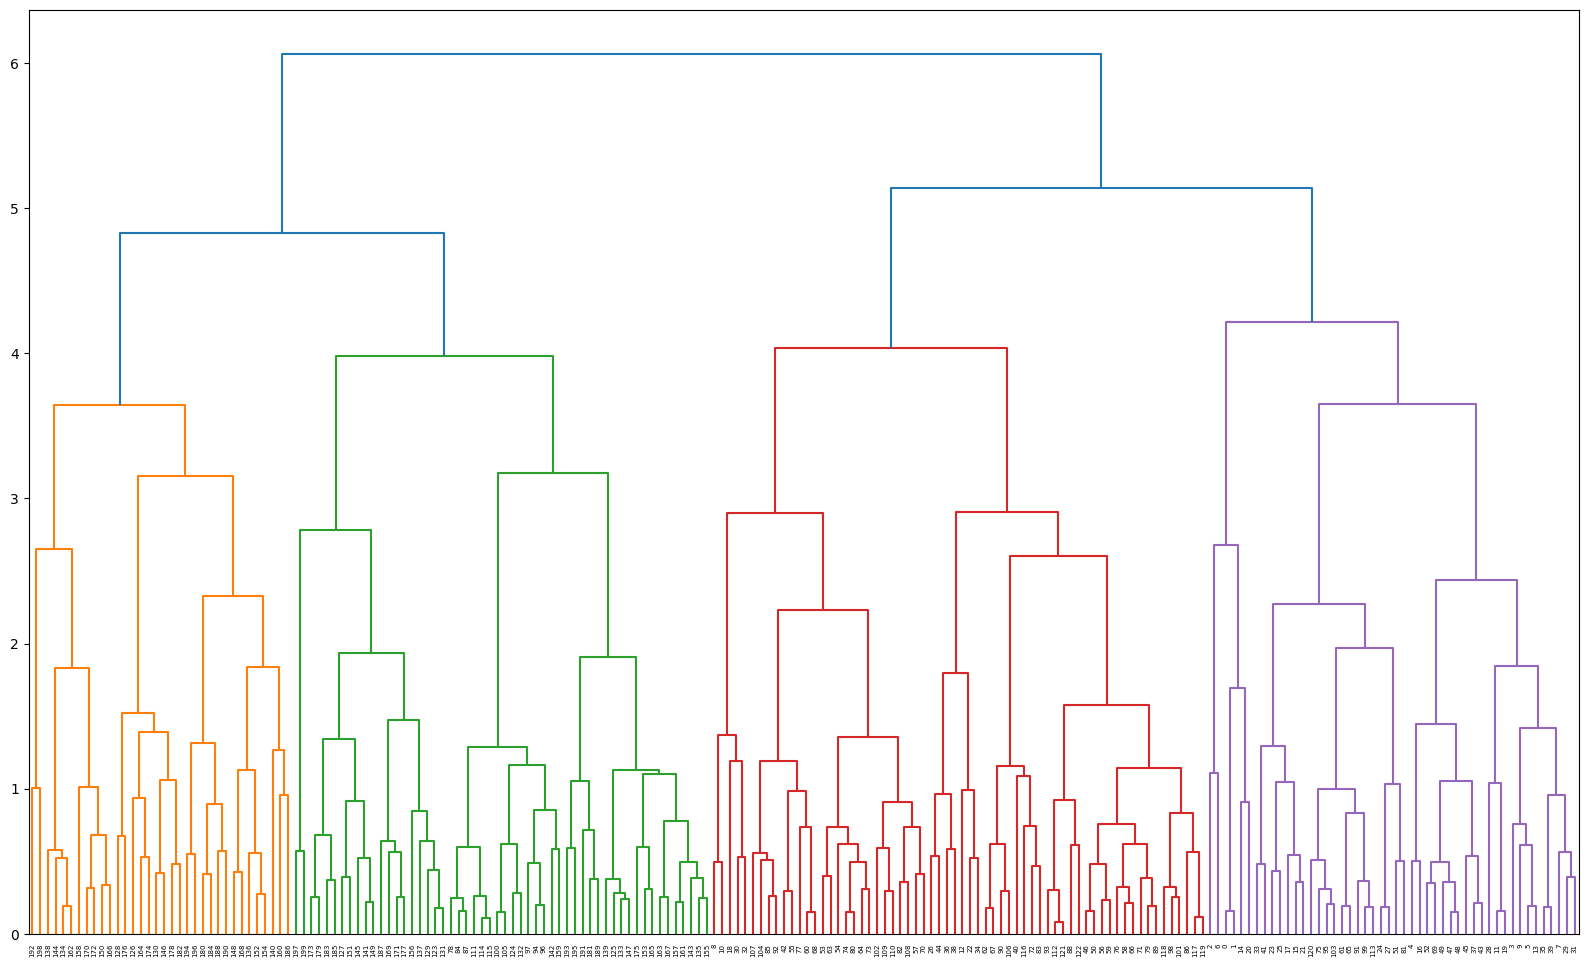

single


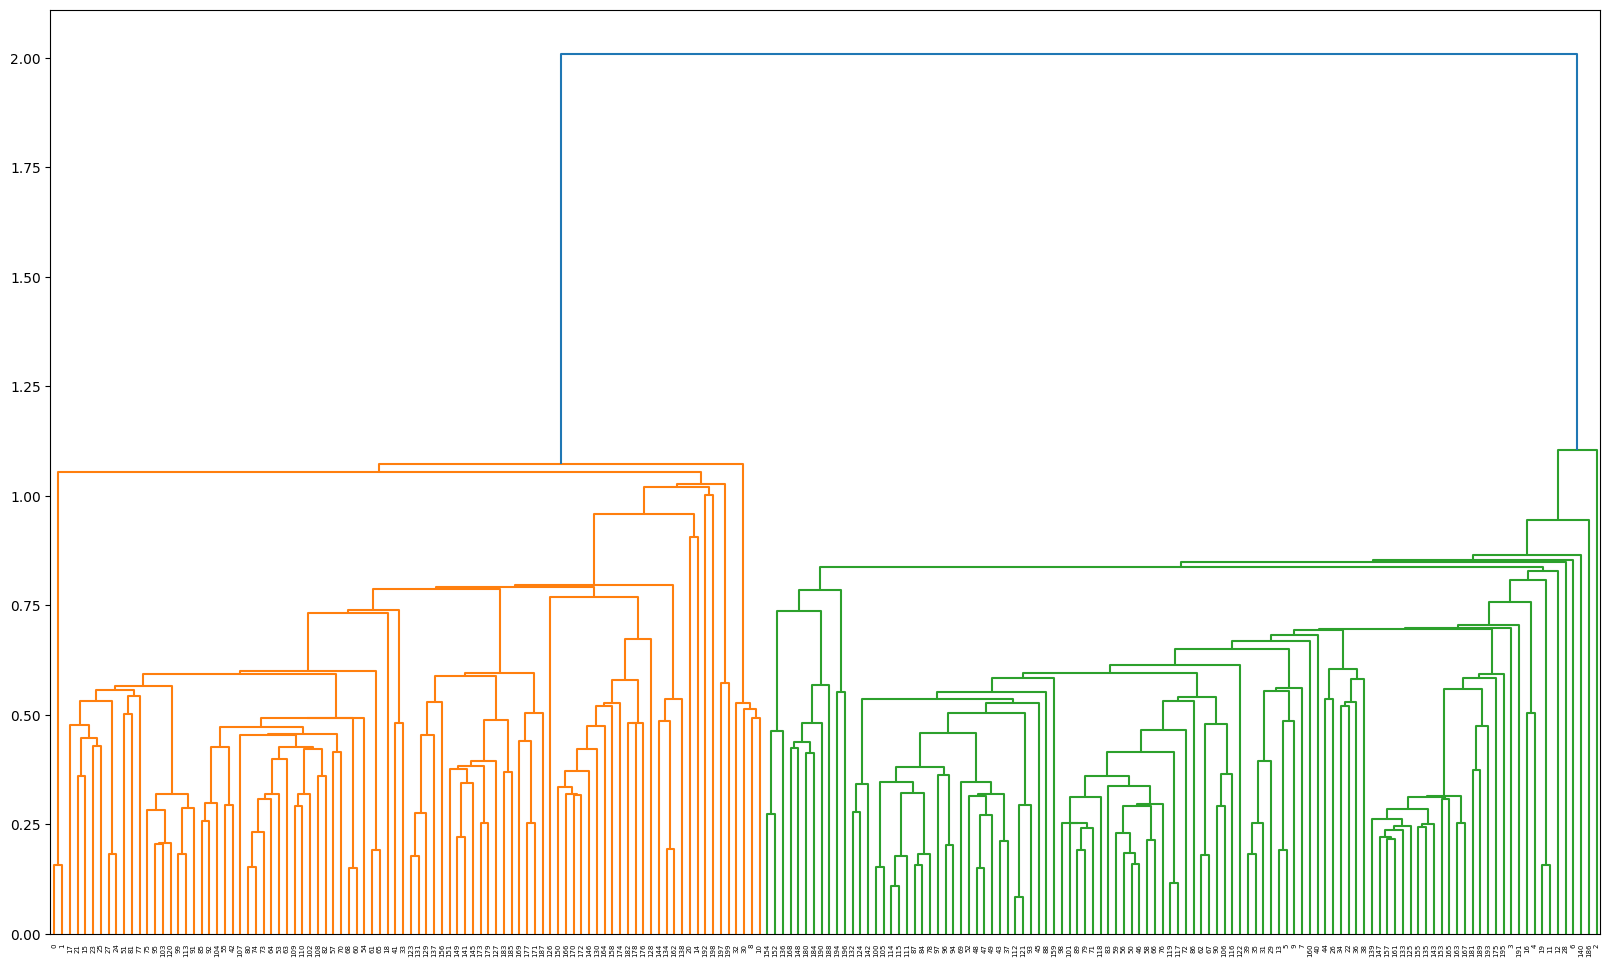

In [38]:
for linkage in ("ward", "average", "complete", "single"):
    clustering = AgglomerativeClustering(linkage=linkage, n_clusters=None,
                            distance_threshold = 0)
    clustering.fit(clientes_imputed_scale)
    print(linkage)
    
    plt.clf()
    NuestrasFunciones.plot_dendogram(clustering)
    #plot_clustering(X_scaled, clustering.labels_, "%s linkage" % linkage)
plt.show()

¿Cuál es el método de linkage más adecuado a la vista de los dendogramas? ¿Cuantos grupos de clientes formarías en base a las alturas del dendograma del linkage escogido?

**Respuesta**:

El criterio de linkage de Ward parece ser el que nos da clsuters más diferenciados los unos de los otros,con tamaños similares y líneas largas.
Para escoger cuántos clusters hay que mirar la longitud de las líneas en el dendograma, si cortamos en 4 clusters estamos cortando líneas muy pequeñas, si seguimos bajando podemos ver que hay 8 clusters que están bien diferenciados y que su corte elimina líneas largas. Yo me decanto por 8 clusters

## Pregunta 13

Explora el clustering K-means con distinto número de grupos y decide cuantos el número de clusters óptimo para la solución según este método. Comenta las métricas de evaluación.

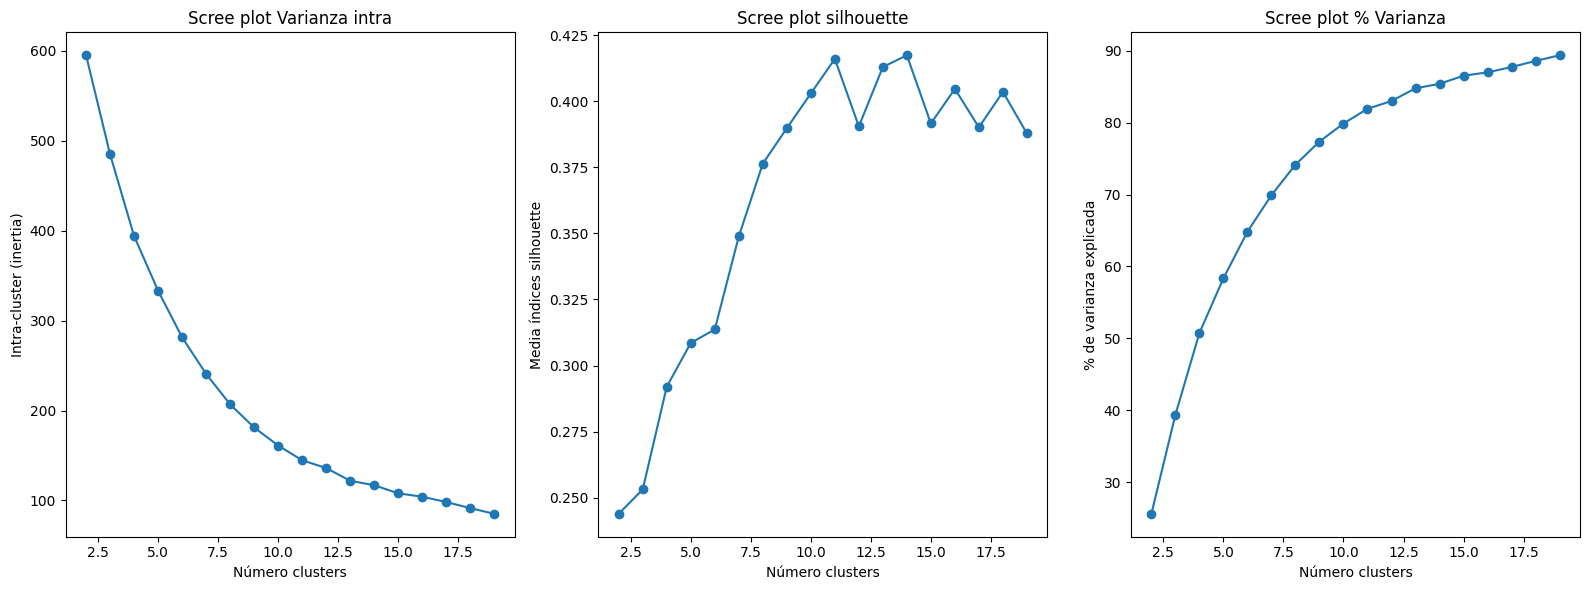

In [39]:
# Clustering k-means evaluación número clusters
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
NuestrasFunciones.scree_plot_kmeans(clientes_imputed,20)

In [40]:
siluetas = []
indices_silu = []

calinski = []
indices_cali =[] 
for i in range(2,20):
    
    modelo_kmeans = KMeans(
                          n_clusters   = i, 
                          n_init       = 5, 
                          random_state = 123 #mismo random state que función que hace el plot de arriba
                      )
    modelo_kmeans.fit(clientes_imputed_scale)
    cluster_labels = modelo_kmeans.labels_
    silueta = silhouette_score(clientes_imputed_scale, modelo_kmeans.labels_)
    siluetas.append(silueta)
    indices_silu.append(i)

    calinski_score = calinski_harabasz_score(clientes_imputed_scale, modelo_kmeans.labels_)
    calinski.append(calinski_score)
    indices_cali.append(i)
    
    print(f"interación = {i} con valor de silueta de {round(silueta,3)} y calinski de {calinski_score}")
    
print(f"valor maximo de silueta = {max(siluetas)}")
indice_max_silu = siluetas.index(max(siluetas))
print(f"se consigue el valor máximo con {indices_silu[indice_max_silu]} clusters")

print(f"valor maximo de calinski-harabaz = {max(calinski)}")
indice_max_cal = calinski.index(max(calinski))
print(f"se consigue el valor máximo con {indices_cali[indice_max_cal]} clusters")

interación = 2 con valor de silueta de 0.244 y calinski de 68.20198006985429
interación = 3 con valor de silueta de 0.244 y calinski de 62.96233471683274
interación = 4 con valor de silueta de 0.293 y calinski de 67.29674133094927
interación = 5 con valor de silueta de 0.309 y calinski de 67.68550720892011
interación = 6 con valor de silueta de 0.318 y calinski de 69.64357498354624
interación = 7 con valor de silueta de 0.349 y calinski de 74.73687300369218
interación = 8 con valor de silueta de 0.364 y calinski de 75.90697050308636
interación = 9 con valor de silueta de 0.39 y calinski de 81.57357691722656
interación = 10 con valor de silueta de 0.385 y calinski de 77.93617121174374
interación = 11 con valor de silueta de 0.416 y calinski de 85.60399218841559
interación = 12 con valor de silueta de 0.399 y calinski de 82.2875152522959
interación = 13 con valor de silueta de 0.41 y calinski de 86.5814691784026
interación = 14 con valor de silueta de 0.417 y calinski de 83.6002562609000

**Respuesta**: 

Ajusta el clustering K-means con el núemero de grupos seleccionado y genera una nueva variable en el conjunto de datos imputado llamada *'Cluster'* que recoja el número de grupo asignado a cada registro. El tipo de la variable debe ser entero (int).  

In [41]:
# Ajuste de k-means
# Ajuste de k-means
modelo_kmeans = KMeans(
                          n_clusters   = 4, 
                          n_init       = 5#, 
                          #random_state = 123
                      )
modelo_kmeans.fit(clientes_imputed_scale)

# Creación de variable cluster
clientes_imputed["Cluster"] = modelo_kmeans.labels_.astype(int)
#A nuestro dataset escalado no le agregamos la columna de los clusters porque lo usaremos en el próximo PCA.

In [42]:
clientes_imputed.columns

Index(['Gender', 'Age', 'Annual Income (k$)', 'Spending_score', 'Cluster'], dtype='object')

Extrae los centroides de los grupos y comenta las principales características de cada grupo formado. 

In [43]:
# Centroides
centroides = pd.DataFrame(modelo_kmeans.cluster_centers_)
centroides.columns = clientes_imputed.columns[:-1]
centroides 

,Gender,Age,Annual Income (k$),Spending_score
0,-0.922958,0.575599,0.058945,-0.571998
1,0.080257,-0.445167,0.973395,1.184160
2,-0.165814,-0.980237,-0.844743,0.420525
3,1.083473,0.732717,0.049877,-0.734507


**Comentarios**: 

## Pregunta 14

De cara a la proyección de los grupos formados en el espacio de características y dado que estamos en R4. Nos planteamos reducir la dimensionalidad a 2 para poder interpretar con mayor claridad mediante un bonito biplot. 

Para llevar a cabo esta tarea, necesitaremos ajustar un PCA con 2 dimensiones a los datos de entrada al clustering que hemos generado, es decir, tal vez utilizamos el conjunto de datos escalado si lo consideramos necesario. Mostraremos las cargas de las variables en las componentes y haremos una pequeña interpretación inicial de las 2 componentes.


In [44]:
#Veremos rápidamente el KMO para saber qué calidad de resultados podremos obtener del PCA
from factor_analyzer.factor_analyzer import calculate_kmo
kmo = round(calculate_kmo(clientes_imputed_scale)[1],3)
print(f"con un kmo de {kmo} es aceptable intentar un PCA, pero sabemos que tendrá capacidades limitadas")

con un kmo de 0.515 es aceptable intentar un PCA, pero sabemos que tendrá capacidades limitadas


In [45]:
# Ajuste PCA 2 dimensiones
from pca import pca
clientes_imputed_scale = pd.DataFrame(clientes_imputed_scale)
clientes_imputed_scale.columns = clientes_imputed.columns[:-1]

pca_model  = pca(normalize = False,n_components = 2) #detect_outliers = "ht2" concluye que no hay outliers en el dataset
pca_results = pca_model.fit_transform(clientes_imputed_scale)

# Análisis de cargas
pca_model.results['loadings']

[pca] >Extracting column labels from dataframe.
[pca] >Extracting row labels from dataframe.
[pca] >The PCA reduction is performed on the [4] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[2]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


,Gender,Age,Annual Income (k$),Spending_score
PC1,0.277566,0.682472,0.004548,-0.676142
PC2,0.595381,-0.113459,0.783824,0.135163


**Interpretación inicial**:

Nuesto pca sólo logra explicar el 59.43% de la variabilidad del modelo, no es muy útil para explicar nuestro dataset.

En cuánto a las cargas, recordando que las cargas representan el coeficiente de la variable en la combinación lineal que forma a la componente.
- PC1: Podemos observar que la componente principal 1 tiene una carga positiva de magnitud 0.68 para la variable age, esto significa que dentro de la combinación lineal que forma a PC1, age tiene una influencia moderadamente fuerte y positiva. Con spending score ocurre lo contrario, pues tiene una carga negativa de aproximadamente 0.68, la variable tiene una influencia algo fuerte sobre PC1 en sentido negativo. Annual income casi no satura la primera componente, tiene muy poca influencia sobre ella. La variable gender al ser dicotómica se comporta de manera diferente dentro del análisis pca, pero podemos igualmente decir que su influencia positiva sobre PCA1 es leve.

- PC2: En cuanto a la segunda componente, las variable que claramente más se saturas en ella son Annual Income y Gender, ambas en sentido positivo. Esto significa que la combinación lineal que conforma el PC2 tiene coeficientes altos en Annual Income y Gender, es decir que la influencia positiva de ambas en alta sobre la componente, mientras que las variables age y spending score no influyen casi a esta componente principal.

Ahora generamos y mostramos el biplot para interpretar con mayor seguridad las componentes. 

[scatterd] >INFO> Create scatterplot


[pca] >Plot PC1 vs PC2 with loadings.


(<Figure size 2500x1500 with 1 Axes>,
 <Axes: title={'center': '2 Principal Components explain [59.65%] of the variance'}, xlabel='PC1 (33.4% expl.var)', ylabel='PC2 (26.1% expl.var)'>)

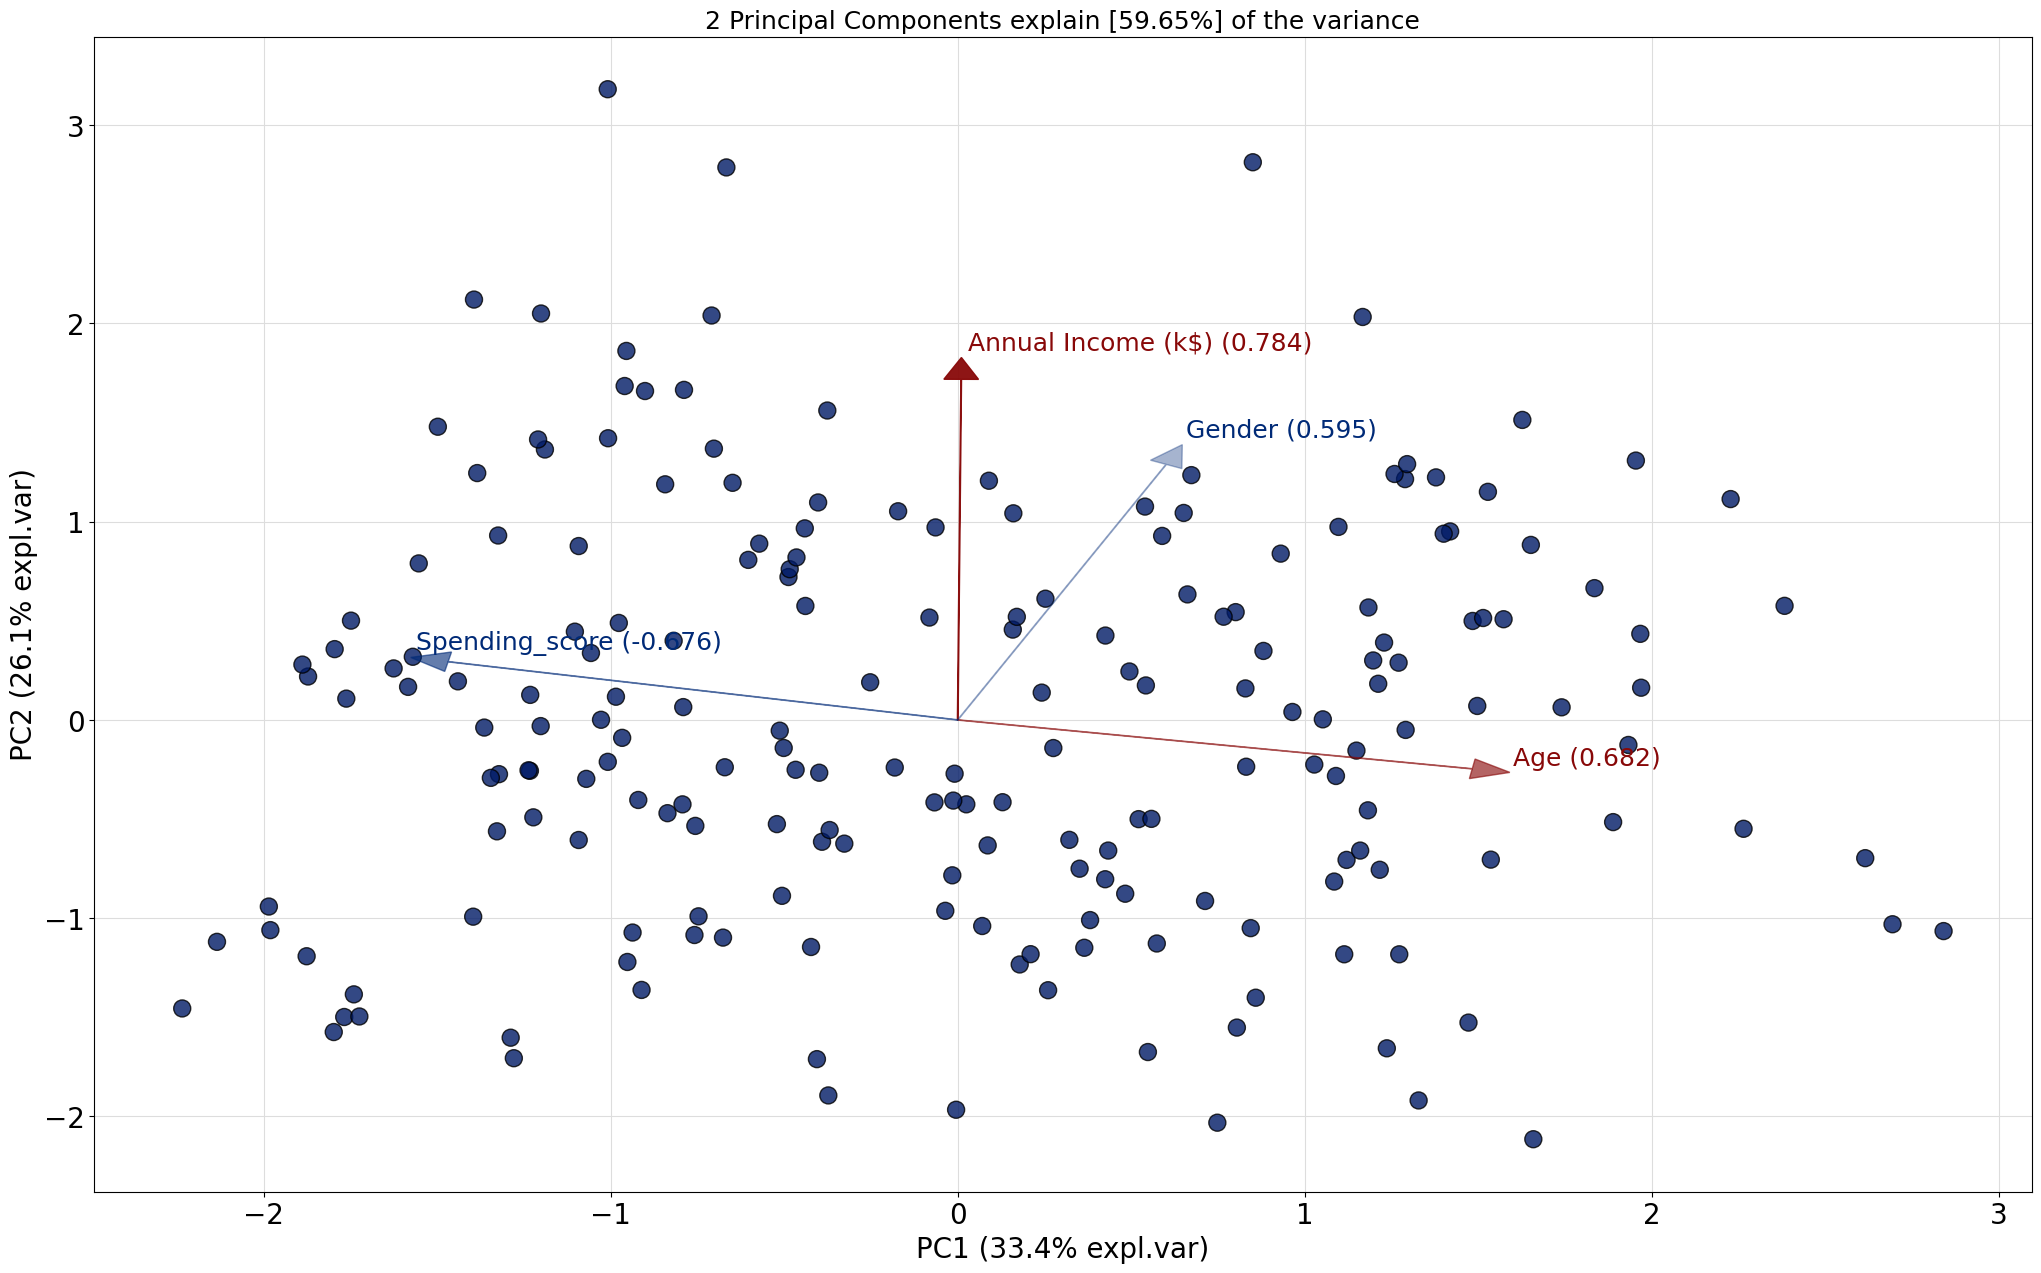

In [46]:
# Biplot
pca_model.biplot()

**Interpretación gráfica**:

La interpretación gráfica, en este caso, no se diferencia mucho de la interpretación de las cargas. La PC1 se nota que es una combinación lineal de age  y gender de manera positiva y de spending score de manera negativa, gráficamente se nota de manera muy clara la baja influencia que tiene Annual Income sobre la PC1, es casi casi completamente perpendicular.

Mientras que PC2 se ve influenciada de manera moderadamente fuerte por annual income y Gender de manera positiva.

Llevé a cabo un análisis factorial de tipo PROMAX por mera curiosidad. La rotación tipo promax logra que Age y Spending Score influyan únicamente en la PC1, pero hace que Annual income se sature en ambas componentes, me parece que el valor interpretativo del pca tiene más valor al hacer que Annual income explique sólo a la componente 2.

Ahora que sabemos lo que represanta cada componente en el espacio original de las variables, necesitamos un conjunto de datos que contenga las columnas *PC1*,*PC2* y *Cluster* para realizar la representación de los clientes por grupos propuestos e interpretar las características de los grupos en el espacio de las componentes. 

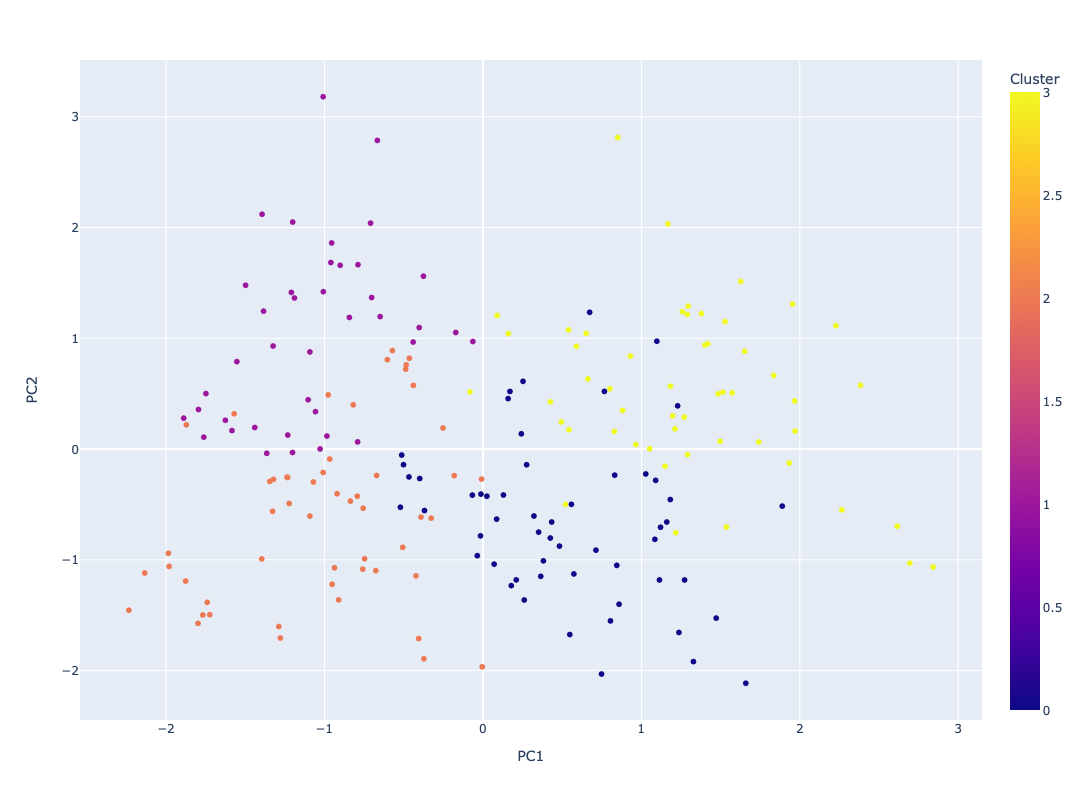

In [47]:
# Creación dataset dimensión reducida
df_reducido = pd.DataFrame()

df_reducido["PC1"] = pca_model.results['PC']["PC1"]
df_reducido["PC2"] = pca_model.results['PC']["PC2"]
df_reducido["Cluster"] = modelo_kmeans.labels_.astype(int)
# Representación de grupos en espacio de componentes
fig = px.scatter(df_reducido,x = "PC1", y = "PC2", color = "Cluster")
fig.update_layout(width=1075, height=800)
fig.show()


**Interpretación de biplot**:

Podemos observar que la separación de los clusters no es total, hay puntos que se alejan de su propio cluster y se adentran en otro diferente. Sin embargo, se puede decir que:
- El cluster 0 es negativo en PC2(bajo annual income, mujer) y positivo en PC1 (alto age/bajo spending socre).
- El cluster 1 es positivo en PC2(alto annual income, hombre) y negativo en PC1 (bajo age/alto spending socre).
- El cluster 2 es levemente positivo en en PC2(alto annual income, hombre) y positivo en PC1 (alto age/bajo spending socre).
- El cluster 3 es levemente negativo en PC2(bajo annual income, mujer) y negativo en PC1 (bajo age/alto spending socre).